## **Overview**
**we will explore how to develop a suite of different types of LSTM models for time series forecasting.**

* ### **Univariate LSTM Models**

1. Data Preparation
2. Vanilla LSTM
3. Stacked LSTM
4. Bidirectional LSTM
5. CNN LSTM
6. ConvLSTM


* ### **Multivariate LSTM Models**

* ### **Multi-Step LSTM Models**

* ### **Multivariate Multi-Step LSTM Models**



In [9]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
# from scikeras.wrappers import KerasRegressor # 回归神经网络

In [10]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
# univariate bidirectional lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
import keras.backend as K
import os
import glob

In [11]:
from PyEMD import CEEMDAN

def get_CEEMD_residue(data: pd.DataFrame):
    """
    Complete Ensemble EMD with Adaptive Noise (CEEMDAN) performs an EEMD
    The difference is that the information about the noise is shared among all workers

    :returns:
    IMFs : numpy array
        All the Intrinsic Mode Functions that make up the original stock price
    residue : numpy array
        The residue from the recently analyzed stock price
    """

    data_np = data['Water Level(m)'].to_numpy()
    print("Data shape:", data_np.shape)
    print("Data array:", data_np)
    ceemd = CEEMDAN()
    ceemd.extrema_detection="parabol"
    ceemd.ceemdan(data_np)
    IMFs, residue = ceemd.get_imfs_and_residue()

    nIMFs = IMFs.shape[0]

    plt.figure(figsize=(18,12))
    plt.subplot(nIMFs + 2, 1, 1)

    plt.plot(data, 'r')
    plt.ylabel("S&P500")

    plt.subplot(nIMFs + 2, 1, nIMFs + 2)
    plt.plot(data.index, residue)
    plt.ylabel("Residue")

    for n in range(nIMFs):
        plt.subplot(nIMFs + 2, 1, n + 2)
        plt.plot(data.index, IMFs[n], 'g')
        plt.ylabel("eIMF %i" % (n + 1))
        plt.locator_params(axis='y', nbins=4)

    plt.tight_layout()
    plt.show()

    return IMFs, residue, nIMFs

def plot_IMFs(IMFs: np.ndarray, residue: np.ndarray, num_IMFs: int, data: pd.DataFrame):
    """
    This function aims to reconstruct the Time Series using the IMFs

    :param IMFs: The IMFs returned from using any of the decomposition functions above
    :param residue: The residue returned from using any of the decomposition functions above
    :param num_IMFs: The number of IMFs you want to reconstruct your data. A value of 2 means the last two IMFs
    :return: None
    """

    sum_IMFs = sum(IMFs[-num_IMFs:])
    sum_IMFs += residue

    plt.figure(figsize=(12, 10))
    plt.plot(data.index, data, label="Stock Price")
    plt.plot(data.index, sum_IMFs, label=f"Last {num_IMFs} IMFs")
    plt.legend(loc="upper left")
    plt.show()

## Univariate LSTM Models
LSTMs can be used to model univariate time series forecasting problems.

These are problems comprised of a single series of observations and a model is required to learn from the series of past observations to predict the next value in the sequence.

We will demonstrate a number of variations of the LSTM model for univariate time series forecasting

## 1. Data Preparation

In [12]:
def LSTM_ALL(file_name):

    df = pd.read_csv('../../Data/NOAA/All Station/{}'.format(file_name))

    # 'Wind Speed (m/s)', 'Wind Dir (deg)','Wind Gust (m/s)', 'Air Temp (°C)', 'Baro (mb)', 'Water Level(m)'
    # df = df[['Wind Speed (m/s)', 'Wind Dir (deg)','Wind Gust (m/s)','Water Level(m)']]

    # 将日期和时间合并为一个列，并将其设置为DataFrame的索引
    df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time (GMT)'])
    df.set_index('DateTime', inplace=True)
    df = df[['Wind Speed (m/s)', 'Wind Dir (deg)', 'Wind Gust (m/s)', 'Air Temp (°C)', 'Baro (mb)', 'Water Level(m)']]
    # 将数据分割为训练集和测试集
    # train_months = [1, 2, 4, 5, 7, 8, 10, 11]
    # test_months = [12]

    # df = df[['SW_IN_F_F','SW_IN_F','TA_F_F', 'TA_F']]

    # 通过第一个_和第二个_截取站点名词
    first_underscore_index = file_name.find("_")
    second_underscore_index = file_name.find("_", first_underscore_index + 1)
    site_name = file_name[first_underscore_index + 1:second_underscore_index]
    print('For '+site_name)

    # 数据范围过大，对数据进行归一化
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(df)

    # #数据集划分
    # test_split = round(len(df) * 0.20)
    # print(test_split)

    # def splitData(var, per_test):
    #     num_test = int(len(var) * per_test)
    #     train_size = int(len(var) - num_test)
    #     train_data = var[0:train_size]
    #     test_data = var[train_size:train_size + num_test]
    #     return train_data, test_data

    # df_training = dataset[df.index.month.isin(train_months)]
    # df_testing = dataset[df.index.month.isin(test_months)]

    # df_training, df_testing = splitData(df, 0.2)
    print(df_training.shape)
    print(df_testing.shape)

    def createXY(dataset, n_past):
        data_X = []
        data_Y = []
        for i in range(n_past, len(dataset)):
         data_X.append(dataset[i - n_past:i, 0:dataset.shape[1]])
         data_Y.append(dataset[i, 5])
        return np.array(data_X), np.array(data_Y)

    trainX, trainY = createXY(df_training, 1)
    testX, testY = createXY(df_testing, 1)

    print('trainX.Shape:----', trainX.shape)
    print('trainY.shape:----', trainY.shape)
    print('testX.shape:----', testX.shape)
    print('testY.shape:----', testY.shape)

    # dfs = pd.read_csv('../../Data/NOAA/All Station/{}'.format(file_name))
    # def splitDataS(var, per_val, per_test):
    #     num_val = int(len(var) * per_val)
    #     num_test = int(len(var) * per_test)
    #     train_size = int(len(var) - num_val - num_test)
    #     train_data = var[0:train_size]
    #     val_data = var[train_size:train_size + num_val]
    #     test_data = var[train_size + num_val:train_size + num_val + num_test]
    #     return train_data, val_data, test_data
    #
    # train,val,test = splitDataS(dfs,0.1,0.1)

    # test_len = len(test)

    def Result_Ana(Model, feature_num,Model_Name):
        y_pred = Model.predict(testX)
        y_pred = np.array(y_pred).reshape(-1, 1)
        y_pred
        y_pred.shape
        prediction_copies_array = np.repeat(y_pred, feature_num,
                                            axis=-1)  #将一个数组prediction在最后一个轴上（即axis=-1）进行复制，重复8次，并将结果存储在prediction_copies_array数组中
        prediction_copies_array
        prediction_copies_array.shape
        pred = scaler.inverse_transform(np.reshape(prediction_copies_array, (len(y_pred), feature_num)))[:,
               5]  #进行逆变换但是，只需要最后一列
        pred.shape
        pred
        # print(pred)
        original_copies_array = np.repeat(testY, feature_num, axis=-1)
        y_true = scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), feature_num)))[:, 5]
        # print('y_true1:',y_true)
        y_true = y_true
        # print('y_true2:',y_true)
        pred = pred
        print(y_true)
        plt.plot(y_true, color='red', label='Real Value')
        plt.plot(pred, color='blue', label='Pred Value')
        plt.title('Prediction SW_IN_F ')
        plt.xlabel('Time')
        plt.ylabel('Detail Value')
        plt.legend()
        # plt.savefig('../Images/SW_IN_F_Train_'+'n_past='+'{}'.format((trainX[1].shape)[0])+'_epochs={}'.format((grid_search.best_params_)['epochs'])+'.png',dpi=600)
        plt.show()
        # y_true_data = pd.DataFrame(y_true)
        # y_true_data.to_csv('../../ResultAnaAndProcess/NOAA_WL/WS_WD_WG_WL/LSTM/{}'.format(Model_Name)+'_{}'.format(site_name) + '_True' + '.csv',index=False)
        # pred_data = pd.DataFrame(pred)
        # pred_data.to_csv('../../ResultAnaAndProcess/NOAA_WL/WS_WD_WG_WL/LSTM/{}'.format(Model_Name)+'_{}'.format(site_name) + '_Pre' + '.csv',index=False)
        from sklearn.metrics import mean_squared_error as mse
        from sklearn.metrics import mean_absolute_error as mae
        from sklearn.metrics import r2_score as r2
        print('MSE:',mse(y_true,pred))
        print('MAE:',mae(y_true,pred))
        print('R²:',r2(y_true,pred))
        print('RMSE:',np.sqrt(mse(y_true,pred)))
        data = {
        'Metric': ['R2', 'RMSE', 'MAE'],
        'Value': [r2(y_true,pred),np.sqrt(mse(y_true,pred)),mae(y_true,pred)]
         }

        results_seaon = pd.DataFrame(data)
        # 保存DataFrame为CSV文件
        results_seaon.to_csv(site_name+'_'+Model_Name+'_metrics_12'+'.csv', index=False)
    from numpy import array
    from keras.models import Sequential
    from keras.layers import LSTM
    from keras.layers import Dense

    ## LSTM
    # define model
    def N_LSTM():
        model = Sequential()
        model.add(LSTM(200, activation='relu', input_shape=(1, 6)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        return model


    N_LSTM_Model = KerasRegressor(N_LSTM, epochs=40, verbose=1, validation_data=(testX, testY))
    Model_Name_One = 'N_LSTM_Model'
    N_LSTM_Model.fit(trainX, trainY)

    Result_Ana(N_LSTM_Model, 6, Model_Name_One)

    #Stack_LSTM
    def Stack_LSTM():
        model = Sequential()
        model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(1, 6)))
        model.add(LSTM(100, activation='relu'))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        return model
    Stack_LSTM_Model = KerasRegressor(Stack_LSTM, epochs=40, verbose=1, validation_data=(testX, testY))
    Model_Name_Two = 'Stack_LSTM_Model'
    Stack_LSTM_Model.fit(trainX,trainY)
    Result_Ana(Stack_LSTM_Model,6,Model_Name_Two)

    #BiLSTM
    def BiLSTM():
        model = Sequential()
        model.add(Bidirectional(LSTM(200, activation='relu'), input_shape=(1, 6)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        return model
    # history = BiLSTM_Model.fit(trainX,trainY,epochs=30,verbose=1,validation_data=(testX, testY))
    BiLSTM_Model = KerasRegressor(BiLSTM, epochs=40, verbose=1, validation_data=(testX, testY))
    Model_Name_Three = 'BiLSTM_Model'
    BiLSTM_Model.fit(trainX,trainY)
    Result_Ana(BiLSTM_Model,6,Model_Name_Three)


In [13]:
# import os
# import glob
#
# csv_path = '../../Data/PreData/ArtiData'
# csv_files = glob.glob(os.path.join(csv_path,'*.csv'))
#
# for file in csv_files:
#  LSTM_ALL(os.path.basename(file))
#  print(os.path.basename(file))
#  print("-------------------------")
import os
import glob
## 0-3 , 3-5,5-7,7-9,9-12
csv_path = '../../Data/NOAA/All Station'
csv_files = glob.glob(os.path.join(csv_path, '*.csv'))

start_index = 0  # 起始索引，即第1个文件
end_index = 5 # 结束索引，即第3个文件

for index, file in enumerate(csv_files[start_index:end_index]):
    LSTM_ALL(os.path.basename(file))
    print(os.path.basename(file))
    print("-------------------------")

For Burlington Station.cs


NameError: name 'df_training' is not defined

In [15]:

def data_IMFs(data):
    imfs = pd.read_excel(data)
    imfs

In [18]:
# import os
# import glob
#
# csv_path = '../../Data/PreData/ArtiData'
# csv_files = glob.glob(os.path.join(csv_path, '*.csv'))
#
# start_index = 10  # 起始索引，即第4个文件
# end_index = 12  # 结束索引，即第6个文件（不包括第7个文件）
#
# for index, file in enumerate(csv_files[start_index:end_index]):
#     # LSTM_ALL(os.path.basename(file))
#     print(os.path.basename(file))
#     print("-------------------------")

IMF = []
xlsx_file = 'CEEMDAN_Data/IMF_13_R/NewTest'
xlsx_path = glob.glob(os.path.join(xlsx_file,'*.xlsx'))

data_col_len = pd.read_excel('CEEMDAN_Data/IMF_13_R/NewTest/CEEMDAN_Burlington Station_WL.xlsx')

for imf_len in range(len(data_col_len.columns)):
    for file in xlsx_path:
         print(file)
         # print(os.path.basename(file))
         imfs = pd.read_excel(file)
         imfn = imfs.iloc[:,imf_len]
         imfn.to_numpy()
         IMF.append(imfn)
    print(imf_len,"-------------------")

CEEMDAN_Data/IMF_13_R/NewTest\CEEMDAN_Burlington Station_AT.xlsx
CEEMDAN_Data/IMF_13_R/NewTest\CEEMDAN_Burlington Station_Baro.xlsx
CEEMDAN_Data/IMF_13_R/NewTest\CEEMDAN_Burlington Station_WD.xlsx
CEEMDAN_Data/IMF_13_R/NewTest\CEEMDAN_Burlington Station_WG.xlsx
CEEMDAN_Data/IMF_13_R/NewTest\CEEMDAN_Burlington Station_WL.xlsx
CEEMDAN_Data/IMF_13_R/NewTest\CEEMDAN_Burlington Station_WS.xlsx
0 -------------------
CEEMDAN_Data/IMF_13_R/NewTest\CEEMDAN_Burlington Station_AT.xlsx
CEEMDAN_Data/IMF_13_R/NewTest\CEEMDAN_Burlington Station_Baro.xlsx
CEEMDAN_Data/IMF_13_R/NewTest\CEEMDAN_Burlington Station_WD.xlsx
CEEMDAN_Data/IMF_13_R/NewTest\CEEMDAN_Burlington Station_WG.xlsx
CEEMDAN_Data/IMF_13_R/NewTest\CEEMDAN_Burlington Station_WL.xlsx
CEEMDAN_Data/IMF_13_R/NewTest\CEEMDAN_Burlington Station_WS.xlsx
1 -------------------
CEEMDAN_Data/IMF_13_R/NewTest\CEEMDAN_Burlington Station_AT.xlsx
CEEMDAN_Data/IMF_13_R/NewTest\CEEMDAN_Burlington Station_Baro.xlsx
CEEMDAN_Data/IMF_13_R/NewTest\CEEMDAN_Bu

In [19]:
IMF[83][1]

2.550772709599891

In [68]:
# df = pd.read_excel('CEEMDAN_Data/results_Burlington Station_AT.xlsx')
# df

,IMF1,IMF2,IMF3,IMF4,IMF5,IMF6,IMF7,IMF8,IMF9,IMF10,IMF11,IMF12,IMF13,Residual
0,-0.033828,0.023025,-0.229006,-0.187968,0.057405,0.335733,-1.976478,-0.305790,-0.410745,-0.641850,0.619778,-0.602289,0.923267,4.228745
1,-0.120510,0.021154,-0.404673,-0.158613,0.095930,0.369184,-2.011840,-0.304776,-0.412316,-0.643379,0.620278,-0.602513,0.923337,4.228737
2,0.108706,-0.084826,-0.174864,-0.123642,0.128295,0.382339,-2.043766,-0.303812,-0.413690,-0.644909,0.620772,-0.602737,0.923406,4.228728
3,-0.337743,-0.013265,-0.103795,-0.009508,0.155401,0.374779,-2.072145,-0.302913,-0.414867,-0.646438,0.621259,-0.602960,0.923476,4.228720
4,-0.316090,0.084231,0.246660,0.143378,0.183242,0.350298,-2.096609,-0.302104,-0.415852,-0.647968,0.621740,-0.603184,0.923546,4.228711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8772,0.297783,0.085342,0.224087,0.243745,-0.015514,1.415649,0.655405,-1.248864,-0.634797,-0.463312,0.327637,0.449764,0.927064,3.536011
8773,1.060568,0.102266,0.113059,-0.243996,-0.073754,1.389236,0.646374,-1.234875,-0.633458,-0.463655,0.325759,0.449435,0.927030,3.536010
8774,-0.228767,0.010369,-0.216563,-0.513965,-0.144210,1.344004,0.632332,-1.223218,-0.632048,-0.463913,0.323874,0.449104,0.926994,3.536008
8775,-1.133619,-0.167837,-0.653397,-0.566877,-0.199445,1.282060,0.613918,-1.213868,-0.630564,-0.464087,0.321980,0.448772,0.926958,3.536006


In [42]:
# df = pd.read_csv('../../Data/NOAA/All Station/Burlington Station.csv')
# df

,Date,Time (GMT),Wind Speed (m/s),Wind Dir (deg),Wind Gust (m/s),Air Temp (°C),Baro (mb),Water Level(m)
0,2022/1/1,0:00,0.9,192,1.8,10.3,1014.2,2.411
1,2022/1/1,1:00,1.0,223,1.6,10.3,1014.3,2.436
2,2022/1/1,2:00,1.4,169,2.0,10.2,1013.4,2.104
3,2022/1/1,3:00,1.3,185,1.8,9.7,1013.2,1.677
4,2022/1/1,4:00,1.7,186,2.4,9.8,1013.0,1.255
...,...,...,...,...,...,...,...,...
8772,2023/1/1,19:00,4.1,269,5.8,11.0,1014.3,0.644
8773,2023/1/1,20:00,5.5,262,5.9,10.3,1014.4,1.150
8774,2023/1/1,21:00,2.9,295,3.8,12.2,1014.6,1.749
8775,2023/1/1,22:00,1.9,249,2.1,10.5,1014.8,2.114


In [64]:
# df = pd.read_csv('../../Data/NOAA/All Station/Burlington Station.csv')

In [65]:
# df_colum = df[['Wind Speed (m/s)','Wind Dir (deg)','Wind Gust (m/s)','Air Temp (°C)','Baro (mb)','Water Level(m)']]

In [66]:
# from PyEMD import CEEMDAN
# def get_CEEMD_residue(data,factor_name):
#     """
#     Complete Ensemble EMD with Adaptive Noise (CEEMDAN) performs an EEMD
#     The difference is that the information about the noise is shared among all workers
#
#     :returns:
#     IMFs : numpy array
#         All the Intrinsic Mode Functions that make up the original stock price
#     residue : numpy array
#         The residue from the recently analyzed stock price
#     """
#
#     data_np = data.to_numpy().reshape(-1)
#     print("Data shape:", data_np.shape)
#     print("Data array:", data_np)
#     ceemd = CEEMDAN()
#     ceemd.extrema_detection="parabol"
#     ceemd.ceemdan(data_np)
#     IMFs, residue = ceemd.get_imfs_and_residue()
#     print(residue[0:10])
#     nIMFs = IMFs.shape[0]
#
#     # # 创建 DataFrame 存储 IMFs 和 residue 数据
#     # imf_df = pd.DataFrame(IMFs.T, columns=[f"IMF{i+1}" for i in range(nIMFs)])
#     # residue_df = pd.DataFrame({"Residue": residue})
#     #
#     # # 将 DataFrame 保存为 CSV 文件
#     # imf_df.to_csv("IMFs.csv", index=False)
#     # residue_df.to_csv("Residue.csv", index=False)
#
#     print('nIMFs.Shape',nIMFs)
#     plt.figure(figsize=(18,12))
#     plt.subplot(nIMFs + 2, 1, 1)
#
#     plt.plot(data, 'r')
#     plt.ylabel("S&P500")
#
#     plt.subplot(nIMFs + 2, 1, nIMFs + 2)
#     plt.plot(data.index, residue)
#     plt.ylabel("Residue")
#
#     for n in range(nIMFs):
#         plt.subplot(nIMFs + 2, 1, n + 2)
#         plt.plot(data.index, IMFs[n], 'g')
#         plt.ylabel("eIMF %i" % (n + 1))
#         plt.locator_params(axis='y', nbins=4)
#
#     plt.tight_layout()
#     plt.show()
#     # 创建 DataFrame 存储 IMFs 和 residue 数据
#     column_names_imfs = [f"IMF{i+1}" for i in range(nIMFs)]
#     imf_df = pd.DataFrame(IMFs.T, columns=column_names_imfs)
#     residue_df = pd.DataFrame({"Residue": residue})
#
#     # 合并 IMFs 和 residue DataFrame
#     combined_df = pd.concat([imf_df, residue_df], axis=1)
#
#     # 将 DataFrame 保存为 CSV 文件
#     combined_df.to_csv(factor_name+"_IMFs_and_Residue.csv", index=False)
#     return IMFs, residue, nIMFs
#
# ## 重构IMFs信号
# def plot_IMFs(IMFs: np.ndarray, residue: np.ndarray, num_IMFs: int, data: pd.DataFrame):
#     """
#     This function aims to reconstruct the Time Series using the IMFs
#
#     :param IMFs: The IMFs returned from using any of the decomposition functions above
#     :param residue: The residue returned from using any of the decomposition functions above
#     :param num_IMFs: The number of IMFs you want to reconstruct your data. A value of 2 means the last two IMFs
#     :return: None
#     """
#
#     sum_IMFs = sum(IMFs[-num_IMFs:])
#     sum_IMFs += residue
#
#     plt.figure(figsize=(12, 10))
#     plt.plot(data.index, data, label="Stock Price")
#     plt.plot(data.index, sum_IMFs, label=f"Last {num_IMFs} IMFs")
#     plt.legend(loc="upper left")
#     plt.show()

## 循环分解每个变量

In [52]:
# for df_name in df_colum:
#     df_imf = df[[df_name]]
#     factor_name = df_name.split('(')[0]
#     print('-----------',df_name,'-------------')
#     get_CEEMD_residue(df_imf,factor_name)

In [38]:
from PyEMD import CEEMDAN
def get_CEEMD_residue(data):
    """
    Complete Ensemble EMD with Adaptive Noise (CEEMDAN) performs an EEMD
    The difference is that the information about the noise is shared among all workers

    :returns:
    IMFs : numpy array
        All the Intrinsic Mode Functions that make up the original stock price
    residue : numpy array
        The residue from the recently analyzed stock price
    """

    data_np = data.to_numpy().reshape(-1)
    print("Data shape:", data_np.shape)
    print("Data array:", data_np)
    ceemd = CEEMDAN()
    ceemd.extrema_detection="parabol"
    ceemd.ceemdan(data_np)
    IMFs, residue = ceemd.get_imfs_and_residue()
    print(residue[0:10])
    nIMFs = IMFs.shape[0]

    # # 创建 DataFrame 存储 IMFs 和 residue 数据
    # imf_df = pd.DataFrame(IMFs.T, columns=[f"IMF{i+1}" for i in range(nIMFs)])
    # residue_df = pd.DataFrame({"Residue": residue})
    #
    # # 将 DataFrame 保存为 CSV 文件
    # imf_df.to_csv("IMFs.csv", index=False)
    # residue_df.to_csv("Residue.csv", index=False)

    print('nIMFs.Shape',nIMFs)
    plt.figure(figsize=(18,12))
    plt.subplot(nIMFs + 2, 1, 1)

    plt.plot(data, 'r')
    plt.ylabel("S&P500")

    plt.subplot(nIMFs + 2, 1, nIMFs + 2)
    plt.plot(data.index, residue)
    plt.ylabel("Residue")

    for n in range(nIMFs):
        plt.subplot(nIMFs + 2, 1, n + 2)
        plt.plot(data.index, IMFs[n], 'g')
        plt.ylabel("eIMF %i" % (n + 1))
        plt.locator_params(axis='y', nbins=4)

    plt.tight_layout()
    plt.show()
    # 创建 DataFrame 存储 IMFs 和 residue 数据
    column_names_imfs = [f"IMF{i+1}" for i in range(nIMFs)]
    imf_df = pd.DataFrame(IMFs.T, columns=column_names_imfs)
    residue_df = pd.DataFrame({"Residue": residue})

    # 合并 IMFs 和 residue DataFrame
    combined_df = pd.concat([imf_df, residue_df], axis=1)

    # 将 DataFrame 保存为 CSV 文件
    combined_df.to_csv("IMFs_and_Residue.csv", index=False)
    return IMFs, residue, nIMFs

## 重构IMFs信号
def plot_IMFs(IMFs: np.ndarray, residue: np.ndarray, num_IMFs: int, data: pd.DataFrame):
    """
    This function aims to reconstruct the Time Series using the IMFs

    :param IMFs: The IMFs returned from using any of the decomposition functions above
    :param residue: The residue returned from using any of the decomposition functions above
    :param num_IMFs: The number of IMFs you want to reconstruct your data. A value of 2 means the last two IMFs
    :return: None
    """

    sum_IMFs = sum(IMFs[-num_IMFs:])
    sum_IMFs += residue

    plt.figure(figsize=(12, 10))
    plt.plot(data.index, data, label="Stock Price")
    plt.plot(data.index, sum_IMFs, label=f"Last {num_IMFs} IMFs")
    plt.legend(loc="upper left")
    plt.show()

In [53]:
# IMFS,residue,n = get_CEEMD_residue(df)

In [54]:
# plot_IMFs(IMFS,residue,n,df)

In [25]:
# df

,Water Level(m)
0,2.411
1,2.436
2,2.104
3,1.677
4,1.255
...,...
8772,0.644
8773,1.150
8774,1.749
8775,2.114


In [126]:
df = pd.read_csv('ALL_Factor_ReIMFS_Result_Unknow_14.csv')
df = df[['Pre']]

In [127]:
df

,Pre
0,1.043661
1,1.528238
2,1.963539
3,2.229490
4,2.250084
...,...
1749,0.425246
1750,0.744335
1751,1.128578
1752,1.602291


In [128]:
origin = pd.read_csv('../../Data/NOAA/All Station/Burlington Station.csv')
y_true = origin['Water Level(m)']

In [129]:
y_true

0       2.411
1       2.436
2       2.104
3       1.677
4       1.255
        ...  
8772    0.644
8773    1.150
8774    1.749
8775    2.114
8776    2.251
Name: Water Level(m), Length: 8777, dtype: float64

In [130]:
#数据集划分
# test_split = round(len(y_true) * 0.20)
# print(test_split)
test_split = round(len(y_true) * 0.20)
print(test_split)


def splitData(var, per_test):
    num_test = int(len(var) * per_test)
    train_size = int(len(var) - num_test)
    train_data = var[0:train_size]
    test_data = var[train_size:train_size + num_test]
    return train_data, test_data


df_training, df_testing = splitData(y_true, 0.2)
print(df_training.shape)
print(df_testing.shape)


print("df_testing.shape",len(df_testing))

def createXY(dataset, n_past):
    data_X = []
    data_Y = []
    for i in range(n_past, len(dataset)):
        data_X.append(dataset[i - n_past:i])
        data_Y.append(dataset[i:i+1])

    return np.array(data_X), np.array(data_Y)


# trainX, trainY = createXY(df_training, 1)
testX, testY = createXY(df_testing, 1)

# print('trainX.Shape:----', trainX.shape)
# print('trainY.shape:----', trainY.shape)
print('testX.shape:----', testX.shape)
print('testY.shape:----', testY.shape)
testY

1755
(7022,)
(1755,)
df_testing.shape 1755
testX.shape:---- (1754, 1)
testY.shape:---- (1754, 1)


array([[1.604],
       [2.056],
       [2.34 ],
       ...,
       [1.749],
       [2.114],
       [2.251]])

In [131]:
df

,Pre
0,1.043661
1,1.528238
2,1.963539
3,2.229490
4,2.250084
...,...
1749,0.425246
1750,0.744335
1751,1.128578
1752,1.602291


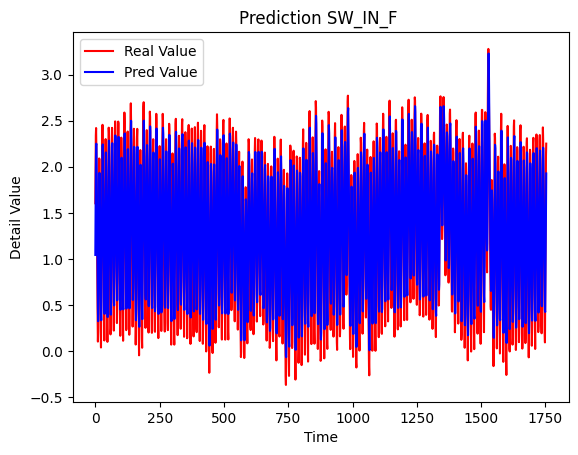

MSE: 0.1395583361075158
MAE: 0.34372197777594077
R²: 0.7680678673160332
RMSE: 0.37357507425886405
pred_finally:            Pre
0     1.043661
1     1.528238
2     1.963539
3     2.229490
4     2.250084
...        ...
1749  0.425246
1750  0.744335
1751  1.128578
1752  1.602291
1753  1.927364

[1754 rows x 1 columns]


In [134]:

y_true = testY
pred = df
plt.plot(y_true, color='red', label='Real Value')
plt.plot(pred, color='blue', label='Pred Value')
plt.title('Prediction SW_IN_F ')
plt.xlabel('Time')
plt.ylabel('Detail Value')
plt.legend()
# plt.savefig('../Images/SW_IN_F_Train_'+'n_past='+'{}'.format((trainX[1].shape)[0])+'_epochs={}'.format((grid_search.best_params_)['epochs'])+'.png',dpi=600)
plt.show()
# y_true_data = pd.DataFrame(y)
# y_true_data.to_csv('../ResultAnaAndProcess/Result/All Features/RF/37390_300/' + 'RF_{}'.format(site_name) + '_True' + '.csv',
#               index=False)
# pred_data = pd.DataFrame(pred)
# pred_data.to_csv('../ResultAnaAndProcess/Result/All Features/RF/37390_300/' + 'RF_{}'.format(site_name) + '_Pre' + '.csv',
#              index=False)
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2

print('MSE:', mse(y_true, pred))
print('MAE:', mae(y_true, pred))
print('R²:', r2(y_true, pred))
print('RMSE:', np.sqrt(mse(y_true, pred)))
print('pred_finally:', pred)


In [75]:
def Result_Ana(Model, feature_num):
    y_pred = Model.predict(testX)
    y_pred = np.array(y_pred).reshape(-1, 1)
    #将一个数组prediction在最后一个轴上（即axis=-1）进行复制，重复8次，并将结果存储在prediction_copies_array数组中
    prediction_copies_array = np.repeat(y_pred, feature_num,axis=-1)
    #prediction_copies_array
    #prediction_copies_array.shape
    pred = scaler.inverse_transform(np.reshape(prediction_copies_array, (len(y_pred), feature_num)))[:,feature_num-1] #进行逆变换但是，只需要最后一列

    # print(pred)
    original_copies_array = np.repeat(testY, feature_num, axis=-1)
    y_true = scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), feature_num)))[:, feature_num-1]
    # y_true = scaler.inverse_transform(np.array(testY).reshape(-1,1))

    y_true
    pred
    print(pred)
    plt.plot(y_true, color='red', label='Real Value')
    plt.plot(pred, color='blue', label='Pred Value')
    plt.title('Prediction SW_IN_F ')
    plt.xlabel('Time')
    plt.ylabel('Detail Value')
    plt.legend()
    # plt.savefig('../Images/SW_IN_F_Train_'+'n_past='+'{}'.format((trainX[1].shape)[0])+'_epochs={}'.format((grid_search.best_params_)['epochs'])+'.png',dpi=600)
    plt.show()
    # y_true_data = pd.DataFrame(y)
    # y_true_data.to_csv('../ResultAnaAndProcess/Result/All Features/RF/37390_300/' + 'RF_{}'.format(site_name) + '_True' + '.csv',
    #               index=False)
    # pred_data = pd.DataFrame(pred)
    # pred_data.to_csv('../ResultAnaAndProcess/Result/All Features/RF/37390_300/' + 'RF_{}'.format(site_name) + '_Pre' + '.csv',
    #              index=False)
    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae
    from sklearn.metrics import r2_score as r2
    print('MSE:',mse(y_true,pred))
    print('MAE:',mae(y_true,pred))
    print('R²:',r2(y_true,pred))
    print('RMSE:',np.sqrt(mse(y_true,pred)))
    print('pred_finally:',pred)

    return pred

1755
(7022, 1)
(1755, 1)
trainX.Shape:---- (7021, 1, 1)
trainY.shape:---- (7021,)
testX.shape:---- (1754, 1, 1)
testY.shape:---- (1754,)
---------------------------- 0 ------------------------------
Epoch 1/30


<timed exec>:69: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


55/55 [==============================] - 1s 6ms/step - loss: 0.1867 - val_loss: 0.0994
Epoch 2/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0451 - val_loss: 0.0097
Epoch 3/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0087 - val_loss: 0.0067
Epoch 4/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0083 - val_loss: 0.0067
Epoch 5/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0082 - val_loss: 0.0067
Epoch 6/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0082 - val_loss: 0.0067
Epoch 7/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0082 - val_loss: 0.0067
Epoch 8/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0082 - val_loss: 0.0067
Epoch 9/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0082 - val_loss: 0.0067
Epoch 10/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0082 - val_loss: 0.0066
Epoch 11/30
55/55 [===========

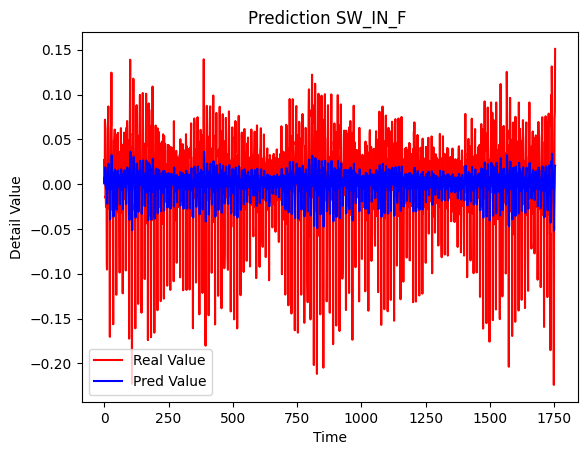

MSE: 0.0025338423950292317
MAE: 0.03567214481216441
R²: 0.026747037917691507
RMSE: 0.050337286329610896
pred_finally: [ 0.00090938  0.00775095  0.0016634  ... -0.0005334   0.01941046
  0.02068633]
prediction_result: [ 0.00090938  0.00775095  0.0016634  ... -0.0005334   0.01941046
  0.02068633]
1755
(7022, 1)
(1755, 1)
trainX.Shape:---- (7021, 1, 1)
trainY.shape:---- (7021,)
testX.shape:---- (1754, 1, 1)
testY.shape:---- (1754,)
---------------------------- 1 ------------------------------
Epoch 1/30


<timed exec>:69: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


55/55 [==============================] - 1s 5ms/step - loss: 0.1306 - val_loss: 0.0746
Epoch 2/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0357 - val_loss: 0.0084
Epoch 3/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0041
Epoch 4/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 5/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 6/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 7/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 8/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 9/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 10/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 11/30
55/55 [===========

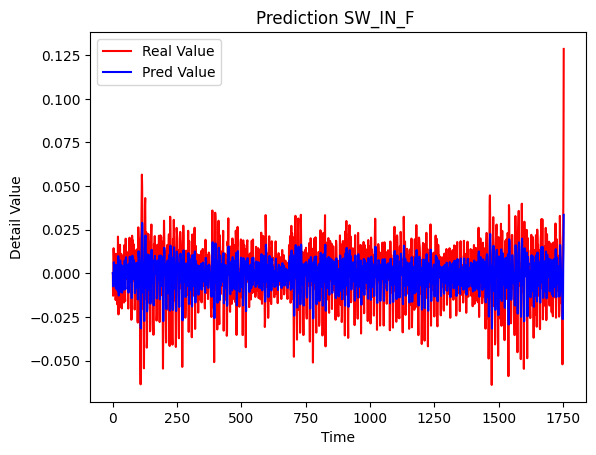

MSE: 0.00019999600898682626
MAE: 0.011222686363561609
R²: 0.2537225651275723
RMSE: 0.014141994519403062
pred_finally: [ 4.4351480e-05 -9.6995529e-04 -7.4637276e-03 ...  3.9581554e-03
  1.4348613e-02  3.3524442e-02]
prediction_result: [ 4.4351480e-05 -9.6995529e-04 -7.4637276e-03 ...  3.9581554e-03
  1.4348613e-02  3.3524442e-02]
1755
(7022, 1)
(1755, 1)
trainX.Shape:---- (7021, 1, 1)
trainY.shape:---- (7021,)
testX.shape:---- (1754, 1, 1)
testY.shape:---- (1754,)
---------------------------- 2 ------------------------------
Epoch 1/30


<timed exec>:69: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


55/55 [==============================] - 1s 5ms/step - loss: 0.2256 - val_loss: 0.1318
Epoch 2/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0777 - val_loss: 0.0331
Epoch 3/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0306 - val_loss: 0.0253
Epoch 4/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0272 - val_loss: 0.0233
Epoch 5/30
55/55 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0213
Epoch 6/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0229 - val_loss: 0.0196
Epoch 7/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0211 - val_loss: 0.0182
Epoch 8/30
55/55 [==============================] - 0s 2ms/step - loss: 0.0197 - val_loss: 0.0171
Epoch 9/30
55/55 [==============================] - 0s 2ms/step - loss: 0.0187 - val_loss: 0.0164
Epoch 10/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0181 - val_loss: 0.0160
Epoch 11/30
55/55 [===========

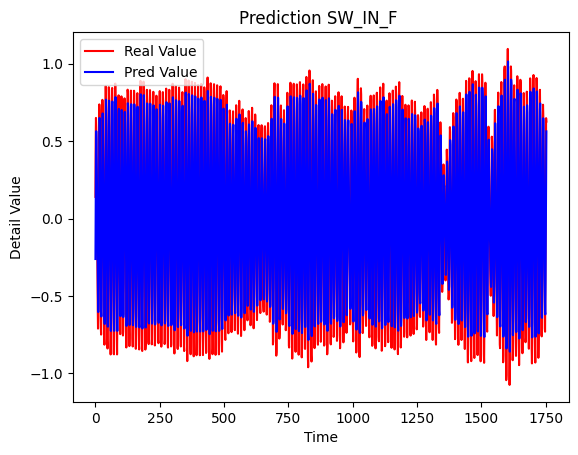

MSE: 0.07891005573314298
MAE: 0.24851600105999588
R²: 0.7526979199356624
RMSE: 0.280909337212459
pred_finally: [-0.2612714   0.09040965  0.41800785 ... -0.08000266  0.31392917
  0.5629478 ]
prediction_result: [-0.2612714   0.09040965  0.41800785 ... -0.08000266  0.31392917
  0.5629478 ]
1755
(7022, 1)
(1755, 1)
trainX.Shape:---- (7021, 1, 1)
trainY.shape:---- (7021,)
testX.shape:---- (1754, 1, 1)
testY.shape:---- (1754,)
---------------------------- 3 ------------------------------
Epoch 1/30


<timed exec>:69: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


55/55 [==============================] - 1s 5ms/step - loss: 0.2046 - val_loss: 0.1307
Epoch 2/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0682 - val_loss: 0.0249
Epoch 3/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0126 - val_loss: 0.0118
Epoch 4/30
55/55 [==============================] - 0s 2ms/step - loss: 0.0098 - val_loss: 0.0114
Epoch 5/30
55/55 [==============================] - 0s 2ms/step - loss: 0.0094 - val_loss: 0.0110
Epoch 6/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0091 - val_loss: 0.0106
Epoch 7/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0087 - val_loss: 0.0101
Epoch 8/30
55/55 [==============================] - 0s 2ms/step - loss: 0.0083 - val_loss: 0.0097
Epoch 9/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0079 - val_loss: 0.0092
Epoch 10/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0076 - val_loss: 0.0088
Epoch 11/30
55/55 [===========

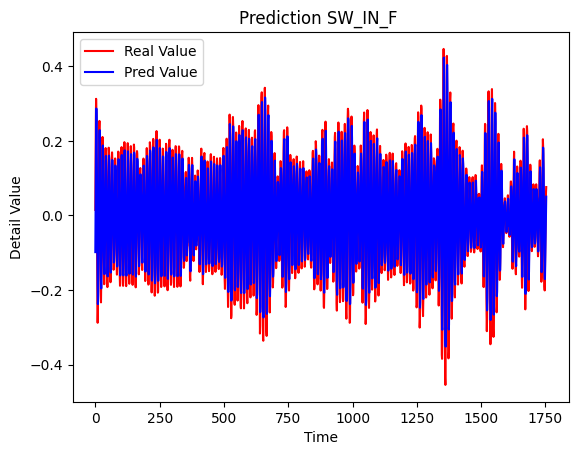

MSE: 0.0051232378480975645
MAE: 0.06086692377342746
R²: 0.7595150596905365
RMSE: 0.07157679685552829
pred_finally: [-0.09839018  0.00986083  0.11836156 ... -0.0451887   0.0009098
  0.0503751 ]
prediction_result: [-0.09839018  0.00986083  0.11836156 ... -0.0451887   0.0009098
  0.0503751 ]
1755
(7022, 1)
(1755, 1)
trainX.Shape:---- (7021, 1, 1)
trainY.shape:---- (7021,)
testX.shape:---- (1754, 1, 1)
testY.shape:---- (1754,)
---------------------------- 4 ------------------------------
Epoch 1/30


<timed exec>:69: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


55/55 [==============================] - 1s 5ms/step - loss: 0.1804 - val_loss: 0.0962
Epoch 2/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0388 - val_loss: 0.0074
Epoch 3/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 4/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 5/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 6/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 7/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 8/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 9/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 10/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 11/30
55/55 [===========

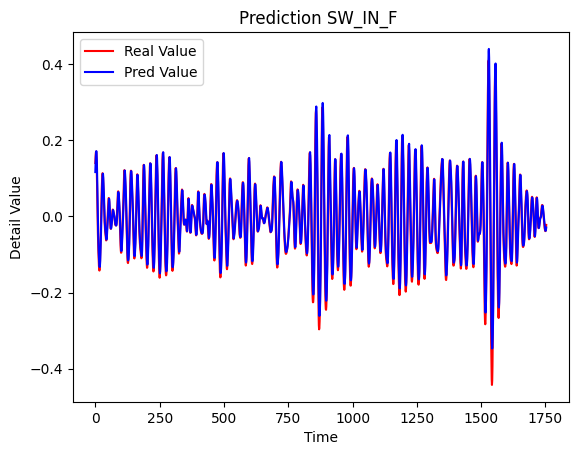

MSE: 0.0007203808047974956
MAE: 0.021041001498101917
R²: 0.933582148203058
RMSE: 0.026839910670445527
pred_finally: [ 0.11627069  0.13966344  0.15717822 ... -0.03802891 -0.03488888
 -0.02942969]
prediction_result: [ 0.11627069  0.13966344  0.15717822 ... -0.03802891 -0.03488888
 -0.02942969]
1755
(7022, 1)
(1755, 1)
trainX.Shape:---- (7021, 1, 1)
trainY.shape:---- (7021,)
testX.shape:---- (1754, 1, 1)
testY.shape:---- (1754,)
---------------------------- 5 ------------------------------
Epoch 1/30


<timed exec>:69: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


55/55 [==============================] - 1s 5ms/step - loss: 0.1642 - val_loss: 0.0973
Epoch 2/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0391 - val_loss: 0.0093
Epoch 3/30
55/55 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0045
Epoch 4/30
55/55 [==============================] - 0s 3ms/step - loss: 7.0989e-04 - val_loss: 0.0045
Epoch 5/30
55/55 [==============================] - 0s 3ms/step - loss: 7.0249e-04 - val_loss: 0.0045
Epoch 6/30
55/55 [==============================] - 0s 3ms/step - loss: 6.9613e-04 - val_loss: 0.0044
Epoch 7/30
55/55 [==============================] - 0s 2ms/step - loss: 6.8898e-04 - val_loss: 0.0044
Epoch 8/30
55/55 [==============================] - 0s 2ms/step - loss: 6.8112e-04 - val_loss: 0.0043
Epoch 9/30
55/55 [==============================] - 0s 3ms/step - loss: 6.7282e-04 - val_loss: 0.0043
Epoch 10/30
55/55 [==============================] - 0s 3ms/step - loss: 6.6396e-04 - val_loss: 0.0042
Ep

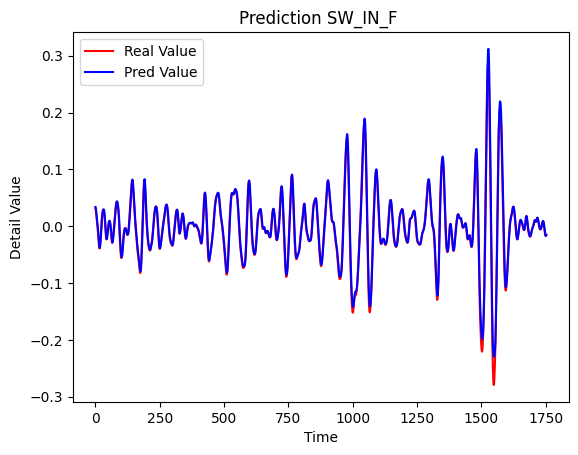

MSE: 8.946001300679016e-05
MAE: 0.00616628387069346
R²: 0.9774410485086242
RMSE: 0.009458330349844531
pred_finally: [ 0.03389569  0.03227231  0.02951414 ... -0.01681062 -0.01644585
 -0.01559233]
prediction_result: [ 0.03389569  0.03227231  0.02951414 ... -0.01681062 -0.01644585
 -0.01559233]
1755
(7022, 1)
(1755, 1)
trainX.Shape:---- (7021, 1, 1)
trainY.shape:---- (7021,)
testX.shape:---- (1754, 1, 1)
testY.shape:---- (1754,)
---------------------------- 6 ------------------------------
Epoch 1/30


<timed exec>:69: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


55/55 [==============================] - 1s 5ms/step - loss: 0.1955 - val_loss: 0.1333
Epoch 2/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0642 - val_loss: 0.0245
Epoch 3/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0087
Epoch 4/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0086
Epoch 5/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0084
Epoch 6/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0081
Epoch 7/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0079
Epoch 8/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0076
Epoch 9/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0074
Epoch 10/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0071
Epoch 11/30
55/55 [===========

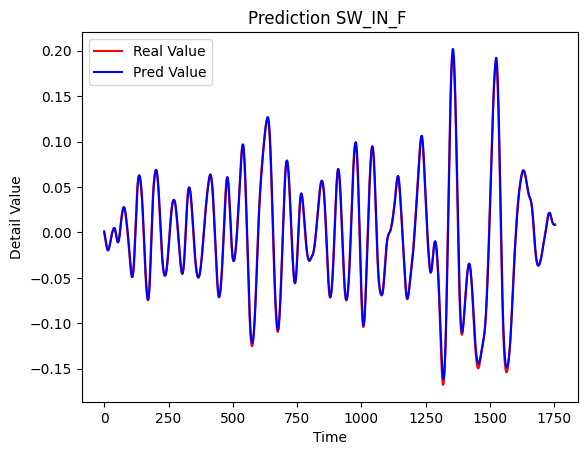

MSE: 2.55680562070193e-05
MAE: 0.004020328112906989
R²: 0.994042577878931
RMSE: 0.005056486547694881
pred_finally: [ 0.00118736 -0.00025064 -0.00182213 ...  0.00840895  0.00842695
  0.00851335]
prediction_result: [ 0.00118736 -0.00025064 -0.00182213 ...  0.00840895  0.00842695
  0.00851335]
1755
(7022, 1)
(1755, 1)
trainX.Shape:---- (7021, 1, 1)
trainY.shape:---- (7021,)
testX.shape:---- (1754, 1, 1)
testY.shape:---- (1754,)
---------------------------- 7 ------------------------------
Epoch 1/30


<timed exec>:69: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


55/55 [==============================] - 1s 5ms/step - loss: 0.1713 - val_loss: 0.0921
Epoch 2/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0338 - val_loss: 0.0079
Epoch 3/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0056
Epoch 4/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0055
Epoch 5/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 0.0053
Epoch 6/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 0.0052
Epoch 7/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 0.0050
Epoch 8/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.0048
Epoch 9/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0047
Epoch 10/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0045
Epoch 11/30
55/55 [===========

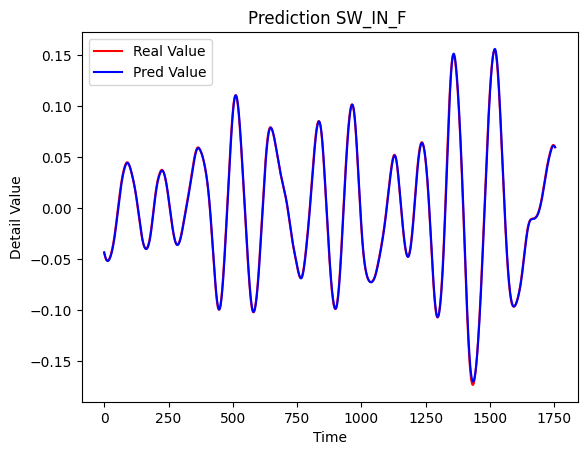

MSE: 7.966574736857166e-06
MAE: 0.0022827029227574093
R²: 0.9980759152339341
RMSE: 0.0028225121322781174
pred_finally: [-0.043439   -0.04463441 -0.04574436 ...  0.06028888  0.05988406
  0.05940434]
prediction_result: [-0.043439   -0.04463441 -0.04574436 ...  0.06028888  0.05988406
  0.05940434]
1755
(7022, 1)
(1755, 1)
trainX.Shape:---- (7021, 1, 1)
trainY.shape:---- (7021,)
testX.shape:---- (1754, 1, 1)
testY.shape:---- (1754,)
---------------------------- 8 ------------------------------
Epoch 1/30


<timed exec>:69: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


55/55 [==============================] - 1s 5ms/step - loss: 0.1531 - val_loss: 0.0884
Epoch 2/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0406 - val_loss: 0.0080
Epoch 3/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 4/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 5/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 6/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 7/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 8/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 9/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 10/30
55/55 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 11/30
55/55 [===========

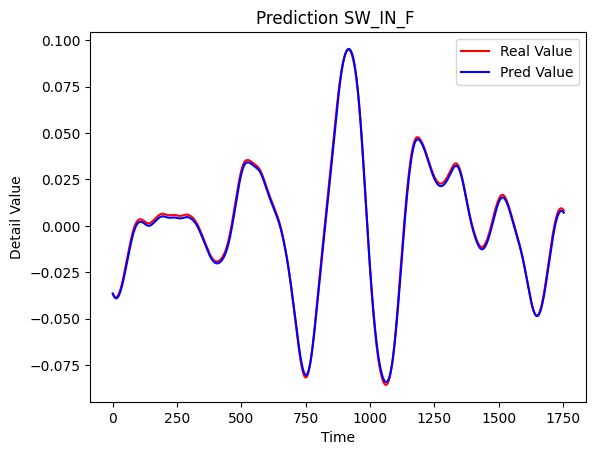

MSE: 1.9791991610921655e-06
MAE: 0.0012730174011385247
R²: 0.9985525027710981
RMSE: 0.0014068401334523285
pred_finally: [-0.03669445 -0.03704449 -0.0373677  ...  0.00745819  0.0072813
  0.00708241]
prediction_result: [-0.03669445 -0.03704449 -0.0373677  ...  0.00745819  0.0072813
  0.00708241]
1755
(7022, 1)
(1755, 1)
trainX.Shape:---- (7021, 1, 1)
trainY.shape:---- (7021,)
testX.shape:---- (1754, 1, 1)
testY.shape:---- (1754,)
---------------------------- 9 ------------------------------
Epoch 1/30


<timed exec>:69: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


55/55 [==============================] - 1s 5ms/step - loss: 0.1779 - val_loss: 0.0930
Epoch 2/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0336 - val_loss: 0.0150
Epoch 3/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0072 - val_loss: 0.0125
Epoch 4/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0065 - val_loss: 0.0113
Epoch 5/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0058 - val_loss: 0.0101
Epoch 6/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0088
Epoch 7/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0044 - val_loss: 0.0076
Epoch 8/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0064
Epoch 9/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0052
Epoch 10/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0042
Epoch 11/30
55/55 [===========

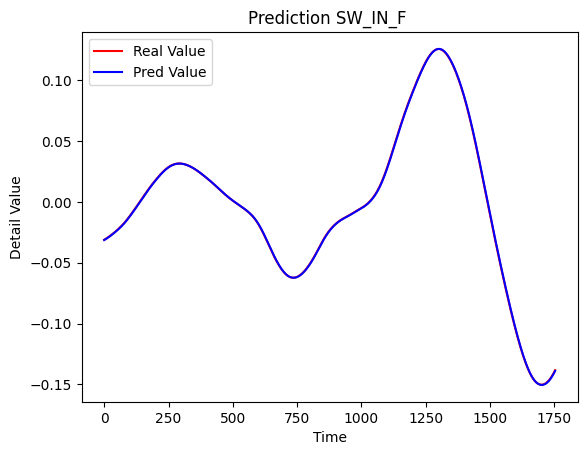

MSE: 2.025727331988091e-07
MAE: 0.0003676368452750672
R²: 0.9999527145462596
RMSE: 0.0004500808074099684
pred_finally: [-0.03130502 -0.03117808 -0.03104999 ... -0.13983391 -0.1394099
 -0.13897799]
prediction_result: [-0.03130502 -0.03117808 -0.03104999 ... -0.13983391 -0.1394099
 -0.13897799]
1755
(7022, 1)
(1755, 1)
trainX.Shape:---- (7021, 1, 1)
trainY.shape:---- (7021,)
testX.shape:---- (1754, 1, 1)
testY.shape:---- (1754,)
---------------------------- 10 ------------------------------
Epoch 1/30


<timed exec>:69: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


55/55 [==============================] - 1s 5ms/step - loss: 0.2017 - val_loss: 0.2050
Epoch 2/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0533 - val_loss: 0.0488
Epoch 3/30
55/55 [==============================] - 0s 2ms/step - loss: 0.0099 - val_loss: 0.0310
Epoch 4/30
55/55 [==============================] - 0s 2ms/step - loss: 0.0084 - val_loss: 0.0279
Epoch 5/30
55/55 [==============================] - 0s 2ms/step - loss: 0.0074 - val_loss: 0.0240
Epoch 6/30
55/55 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0204
Epoch 7/30
55/55 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0165
Epoch 8/30
55/55 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0131
Epoch 9/30
55/55 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0102
Epoch 10/30
55/55 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0075
Epoch 11/30
55/55 [===========

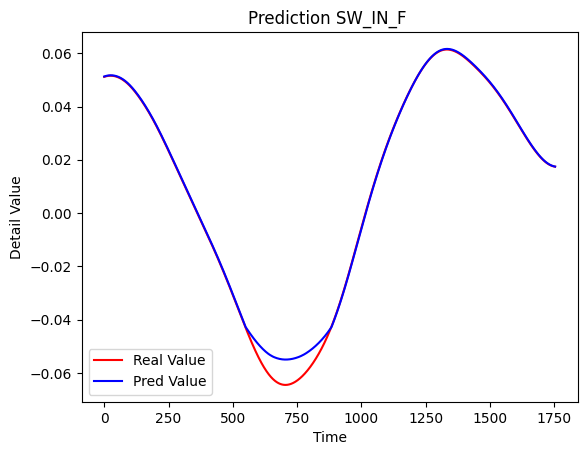

MSE: 8.665864434510934e-06
MAE: 0.0013352033446770413
R²: 0.9950250504318296
RMSE: 0.0029437840332658463
pred_finally: [0.05128022 0.05131428 0.05134702 ... 0.01748759 0.01746899 0.01745214]
prediction_result: [0.05128022 0.05131428 0.05134702 ... 0.01748759 0.01746899 0.01745214]
1755
(7022, 1)
(1755, 1)
trainX.Shape:---- (7021, 1, 1)
trainY.shape:---- (7021,)
testX.shape:---- (1754, 1, 1)
testY.shape:---- (1754,)
---------------------------- 11 ------------------------------
Epoch 1/30


<timed exec>:69: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


55/55 [==============================] - 1s 5ms/step - loss: 0.2177 - val_loss: 0.0465
Epoch 2/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0699 - val_loss: 0.0187
Epoch 3/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0266 - val_loss: 0.0211
Epoch 4/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0194 - val_loss: 0.0144
Epoch 5/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0129 - val_loss: 0.0094
Epoch 6/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0076 - val_loss: 0.0052
Epoch 7/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0022
Epoch 8/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 8.2232e-04
Epoch 9/30
55/55 [==============================] - 0s 3ms/step - loss: 7.7586e-04 - val_loss: 3.2984e-04
Epoch 10/30
55/55 [==============================] - 0s 3ms/step - loss: 4.4054e-04 - val_loss: 1.9793e-04
Epoch 11/3

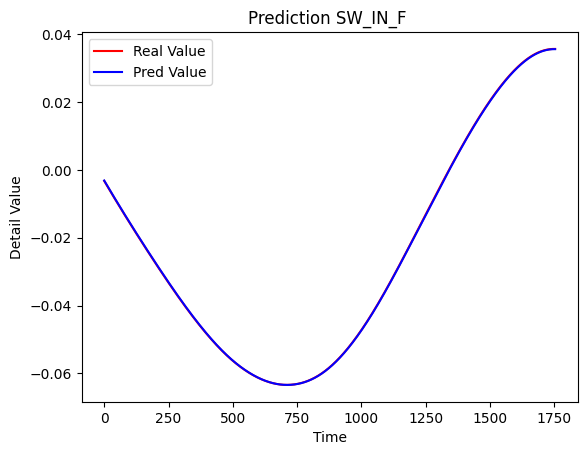

MSE: 1.2437556830934182e-08
MAE: 0.00010258771736912043
R²: 0.9999878940908146
RMSE: 0.00011152379490913221
pred_finally: [-0.00315157 -0.00328053 -0.00340941 ...  0.03557945  0.0355786
  0.03557722]
prediction_result: [-0.00315157 -0.00328053 -0.00340941 ...  0.03557945  0.0355786
  0.03557722]
1755
(7022, 1)
(1755, 1)
trainX.Shape:---- (7021, 1, 1)
trainY.shape:---- (7021,)
testX.shape:---- (1754, 1, 1)
testY.shape:---- (1754,)
---------------------------- 12 ------------------------------
Epoch 1/30


<timed exec>:69: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


55/55 [==============================] - 1s 5ms/step - loss: 0.1628 - val_loss: 0.0373
Epoch 2/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0425 - val_loss: 4.4437e-04
Epoch 3/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0110 - val_loss: 0.0040
Epoch 4/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0092 - val_loss: 0.0030
Epoch 5/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0076 - val_loss: 0.0023
Epoch 6/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0060 - val_loss: 0.0019
Epoch 7/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0015
Epoch 8/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 9.0803e-04
Epoch 9/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 5.8491e-04
Epoch 10/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 2.9830e-04
Epoch 11/30
55

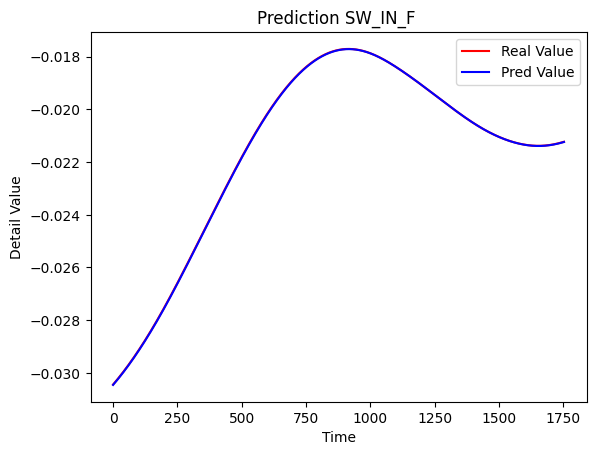

MSE: 2.0743228158768377e-10
MAE: 1.118278582291616e-05
R²: 0.9999836827792784
RMSE: 1.4402509558673578e-05
pred_finally: [-0.03045868 -0.03044726 -0.03043582 ... -0.02124149 -0.02123857
 -0.02123562]
prediction_result: [-0.03045868 -0.03044726 -0.03043582 ... -0.02124149 -0.02123857
 -0.02123562]
1755
(7022, 1)
(1755, 1)
trainX.Shape:---- (7021, 1, 1)
trainY.shape:---- (7021,)
testX.shape:---- (1754, 1, 1)
testY.shape:---- (1754,)
---------------------------- 13 ------------------------------
Epoch 1/30


<timed exec>:69: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


55/55 [==============================] - 1s 5ms/step - loss: 0.5440 - val_loss: 0.0699
Epoch 2/30
55/55 [==============================] - 0s 3ms/step - loss: 0.1781 - val_loss: 8.9320e-04
Epoch 3/30
55/55 [==============================] - 0s 2ms/step - loss: 0.0128 - val_loss: 0.0270
Epoch 4/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0269
Epoch 5/30
55/55 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0263
Epoch 6/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0253
Epoch 7/30
55/55 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0242
Epoch 8/30
55/55 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0239
Epoch 9/30
55/55 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0230
Epoch 10/30
55/55 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0222
Epoch 11/30
55/55 [=======

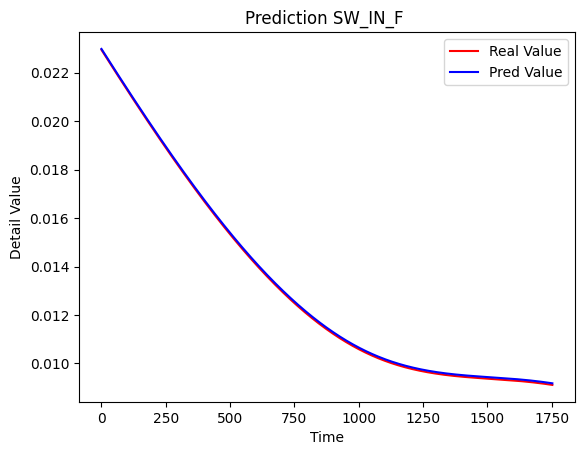

MSE: 3.7101339851040673e-09
MAE: 6.032476598759336e-05
R²: 0.999784344445272
RMSE: 6.091086918690347e-05
pred_finally: [0.02298455 0.02296783 0.02295112 ... 0.00918159 0.00917997 0.00917836]
prediction_result: [0.02298455 0.02296783 0.02295112 ... 0.00918159 0.00917997 0.00917836]
1755
(7022, 1)
(1755, 1)
trainX.Shape:---- (7021, 1, 1)
trainY.shape:---- (7021,)
testX.shape:---- (1754, 1, 1)
testY.shape:---- (1754,)
---------------------------- 14 ------------------------------
Epoch 1/30


<timed exec>:69: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


55/55 [==============================] - 1s 5ms/step - loss: 0.2900 - val_loss: 0.3744
Epoch 2/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0704 - val_loss: 0.0587
Epoch 3/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0056 - val_loss: 0.0150
Epoch 4/30
55/55 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0153
Epoch 5/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0146
Epoch 6/30
55/55 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0133
Epoch 7/30
55/55 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0120
Epoch 8/30
55/55 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0112
Epoch 9/30
55/55 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0105
Epoch 10/30
55/55 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0091
Epoch 11/30
55/55 [===========

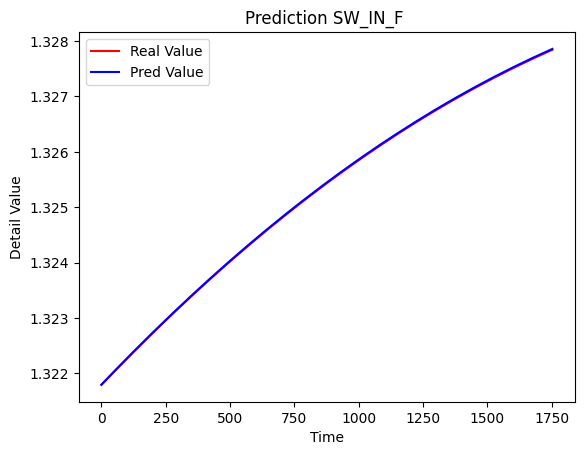

MSE: 1.7999731348488024e-10
MAE: 1.3083464771028087e-05
R²: 0.9999416746357739
RMSE: 1.3416307744117987e-05
pred_finally: [1.321799  1.3218039 1.3218088 ... 1.3278544 1.3278564 1.3278586]
prediction_result: [1.321799  1.3218039 1.3218088 ... 1.3278544 1.3278564 1.3278586]
CPU times: total: 29min 36s
Wall time: 15min 12s


In [77]:
%%time
# df.iloc[-300:,:]
imf_choose = 0
finally_rsult = []
#int(len(IMF)/6)
for imf_run in range(int(len(IMF))):
    # ALL_Factor_IMF = IMF[imf_choose:imf_choose+6][:]
    # imf_choose = imf_choose + 6
    # imf_choose = imf_choose + 6
    # print(ALL_Factor_IMF1)
    # print('--------------------------')
    ALL_Factor_IMF = IMF[imf_run]
    ALL_Factor_IMF = np.array(ALL_Factor_IMF)
    IMF_Input = np.transpose(ALL_Factor_IMF)
    # print(IMF_Input)

    #[AT,Baro,WD,WG,WL,WS]
    IMF_Input
    df_IMF = pd.DataFrame(IMF_Input)
    # df_IMF.columns = ['AT','Baro','WD','WG','WL','WS']
    df_IMF.columns = ['WL']
    df_IMF[['WL']]


    # 数据范围过大，对数据进行归一化
    scaler = MinMaxScaler(feature_range=(0, 1))
    df = scaler.fit_transform(df_IMF)

    #数据集划分
    test_split = round(len(df) * 0.20)
    print(test_split)
    def splitData(var, per_test):
        num_test = int(len(var) * per_test)
        train_size = int(len(var) - num_test)
        train_data = var[0:train_size]
        test_data = var[train_size:train_size + num_test]
        return train_data, test_data
    df_training, df_testing = splitData(df, 0.2)
    print(df_training.shape)
    print(df_testing.shape)

    def createXY(dataset, n_past):
        data_X = []
        data_Y = []
        for i in range(n_past, len(dataset)):
            data_X.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            data_Y.append(dataset[i, 0])

        return np.array(data_X), np.array(data_Y)


    trainX, trainY = createXY(df_training, 1)
    testX, testY = createXY(df_testing, 1)

    print('trainX.Shape:----', trainX.shape)
    print('trainY.shape:----', trainY.shape)
    print('testX.shape:----', testX.shape)
    print('testY.shape:----', testY.shape)
    print('----------------------------',imf_run,'------------------------------')

    def N_LSTM(optimizer='adam', batch_size=32, epochs=40):
        model = Sequential()
        model.add(LSTM(100, activation='relu', input_shape=(1, 1)))
        # optimizer = Adam()  # 设置为您希望的学习率
        model.add(Dense(1))
        model.compile(optimizer=optimizer, loss='mse')
        return model


    N_LSTM_Model = KerasRegressor(N_LSTM, epochs=40, verbose=1, validation_data=(testX, testY))

    from sklearn.model_selection import GridSearchCV

    # 定义超参数搜索范围
    param_grid = {
        'optimizer': ['adam'],
        'batch_size': [64,128],
        'epochs': [30, 50]
    }

    # 执行网格搜索
    grid = GridSearchCV(estimator=N_LSTM_Model, param_grid=param_grid, cv=2)
    grid_result = grid.fit(trainX, trainY)

    best_model = grid_result.best_estimator_

    prediction_result = Result_Ana(best_model, 1)

    print('prediction_result:',prediction_result)
    finally_rsult.append(prediction_result)

In [78]:
finally_rsult

[array([ 0.00090938,  0.00775095,  0.0016634 , ..., -0.0005334 ,
         0.01941046,  0.02068633], dtype=float32),
 array([ 4.4351480e-05, -9.6995529e-04, -7.4637276e-03, ...,
         3.9581554e-03,  1.4348613e-02,  3.3524442e-02], dtype=float32),
 array([-0.2612714 ,  0.09040965,  0.41800785, ..., -0.08000266,
         0.31392917,  0.5629478 ], dtype=float32),
 array([-0.09839018,  0.00986083,  0.11836156, ..., -0.0451887 ,
         0.0009098 ,  0.0503751 ], dtype=float32),
 array([ 0.11627069,  0.13966344,  0.15717822, ..., -0.03802891,
        -0.03488888, -0.02942969], dtype=float32),
 array([ 0.03389569,  0.03227231,  0.02951414, ..., -0.01681062,
        -0.01644585, -0.01559233], dtype=float32),
 array([ 0.00118736, -0.00025064, -0.00182213, ...,  0.00840895,
         0.00842695,  0.00851335], dtype=float32),
 array([-0.043439  , -0.04463441, -0.04574436, ...,  0.06028888,
         0.05988406,  0.05940434], dtype=float32),
 array([-0.03669445, -0.03704449, -0.0373677 , ...,  0

In [79]:
finally_r = np.array(finally_rsult)

In [80]:
finally_r

array([[ 9.0937782e-04,  7.7509480e-03,  1.6633982e-03, ...,
        -5.3339952e-04,  1.9410461e-02,  2.0686327e-02],
       [ 4.4351480e-05, -9.6995529e-04, -7.4637276e-03, ...,
         3.9581554e-03,  1.4348613e-02,  3.3524442e-02],
       [-2.6127139e-01,  9.0409651e-02,  4.1800785e-01, ...,
        -8.0002658e-02,  3.1392917e-01,  5.6294781e-01],
       ...,
       [-3.0458676e-02, -3.0447263e-02, -3.0435821e-02, ...,
        -2.1241490e-02, -2.1238567e-02, -2.1235619e-02],
       [ 2.2984549e-02,  2.2967830e-02,  2.2951124e-02, ...,
         9.1815870e-03,  9.1799730e-03,  9.1783563e-03],
       [ 1.3217990e+00,  1.3218039e+00,  1.3218088e+00, ...,
         1.3278544e+00,  1.3278564e+00,  1.3278586e+00]], dtype=float32)

In [81]:
ALL_Factor_ReIMFS_Result = np.transpose(finally_r)

In [82]:
ALL_Factor_ReIMFS_Result

array([[ 9.0937782e-04,  4.4351480e-05, -2.6127139e-01, ...,
        -3.0458676e-02,  2.2984549e-02,  1.3217990e+00],
       [ 7.7509480e-03, -9.6995529e-04,  9.0409651e-02, ...,
        -3.0447263e-02,  2.2967830e-02,  1.3218039e+00],
       [ 1.6633982e-03, -7.4637276e-03,  4.1800785e-01, ...,
        -3.0435821e-02,  2.2951124e-02,  1.3218088e+00],
       ...,
       [-5.3339952e-04,  3.9581554e-03, -8.0002658e-02, ...,
        -2.1241490e-02,  9.1815870e-03,  1.3278544e+00],
       [ 1.9410461e-02,  1.4348613e-02,  3.1392917e-01, ...,
        -2.1238567e-02,  9.1799730e-03,  1.3278564e+00],
       [ 2.0686327e-02,  3.3524442e-02,  5.6294781e-01, ...,
        -2.1235619e-02,  9.1783563e-03,  1.3278586e+00]], dtype=float32)

In [83]:
finally_column_names = ["IMF1", "IMF2", "IMF3", "IMF4", "IMF5", "IMF6", "IMF7", "IMF8", "IMF9", "IMF10", "IMF11", "IMF12","IMF13","IMF14","Residual"]

In [84]:
all_factor_ceemdan_prediction = pd.DataFrame(ALL_Factor_ReIMFS_Result,columns=finally_column_names)

In [85]:
all_factor_ceemdan_prediction

,IMF1,IMF2,IMF3,IMF4,IMF5,IMF6,IMF7,IMF8,IMF9,IMF10,IMF11,IMF12,IMF13,IMF14,Residual
0,0.000909,0.000044,-0.261271,-0.098390,0.116271,0.033896,0.001187,-0.043439,-0.036694,-0.031305,0.051280,-0.003152,-0.030459,0.022985,1.321799
1,0.007751,-0.000970,0.090410,0.009861,0.139663,0.032272,-0.000251,-0.044634,-0.037044,-0.031178,0.051314,-0.003281,-0.030447,0.022968,1.321804
2,0.001663,-0.007464,0.418008,0.118362,0.157178,0.029514,-0.001822,-0.045744,-0.037368,-0.031050,0.051347,-0.003409,-0.030436,0.022951,1.321809
3,0.001939,-0.002895,0.564314,0.229029,0.168015,0.025789,-0.003511,-0.046769,-0.037664,-0.030921,0.051378,-0.003538,-0.030424,0.022934,1.321814
4,0.018968,0.006364,0.504937,0.286736,0.171235,0.021486,-0.005278,-0.047708,-0.037932,-0.030790,0.051409,-0.003667,-0.030413,0.022918,1.321818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1749,-0.051814,-0.026280,-0.618855,-0.133540,-0.035038,-0.014621,0.008565,0.060846,0.007744,-0.140658,0.017530,0.035579,-0.021247,0.009185,1.327850
1750,-0.008144,-0.018021,-0.398470,-0.082320,-0.037765,-0.016254,0.008455,0.060612,0.007613,-0.140250,0.017508,0.035580,-0.021244,0.009183,1.327852
1751,-0.000533,0.003958,-0.080003,-0.045189,-0.038029,-0.016811,0.008409,0.060289,0.007458,-0.139834,0.017488,0.035579,-0.021241,0.009182,1.327854
1752,0.019410,0.014349,0.313929,0.000910,-0.034889,-0.016446,0.008427,0.059884,0.007281,-0.139410,0.017469,0.035579,-0.021239,0.009180,1.327856


In [86]:
# 保存为CSV文件
all_factor_ceemdan_prediction.to_csv("ALL_Factor_ReIMFS_Result_Unknow_14.csv", index=False)

[3.29393985 3.17161103 2.79588692 ... 3.03236809 3.22370409 3.07573006]


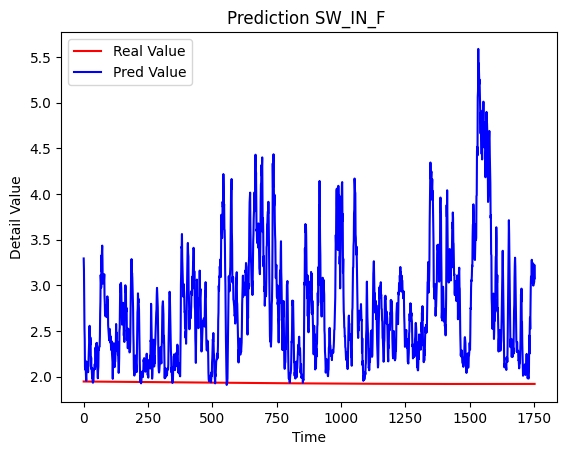

MSE: 1.0749536305890255
MAE: 0.8181927367203466
R²: -14590.632925513468
RMSE: 1.036799706109635
pred_finally: [3.29393985 3.17161103 2.79588692 ... 3.03236809 3.22370409 3.07573006]


In [219]:
y_pred = np.array(df).reshape(-1, 1)
#将一个数组prediction在最后一个轴上（即axis=-1）进行复制，重复8次，并将结果存储在prediction_copies_array数组中
prediction_copies_array = np.repeat(y_pred, 6, axis=-1)
#prediction_copies_array
#prediction_copies_array.shape
pred = scaler.inverse_transform(np.reshape(prediction_copies_array, (len(y_pred), 6)))[:,5]  #进行逆变换但是，只需要最后一列

# print(pred)
original_copies_array = np.repeat(testY, 6, axis=-1)
y_true = scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), 6)))[:, 5]
# y_true = scaler.inverse_transform(np.array(testY).reshape(-1,1))

y_true
pred
print(pred)
plt.plot(y_true, color='red', label='Real Value')
plt.plot(pred, color='blue', label='Pred Value')
plt.title('Prediction SW_IN_F ')
plt.xlabel('Time')
plt.ylabel('Detail Value')
plt.legend()
# plt.savefig('../Images/SW_IN_F_Train_'+'n_past='+'{}'.format((trainX[1].shape)[0])+'_epochs={}'.format((grid_search.best_params_)['epochs'])+'.png',dpi=600)
plt.show()
# y_true_data = pd.DataFrame(y)
# y_true_data.to_csv('../ResultAnaAndProcess/Result/All Features/RF/37390_300/' + 'RF_{}'.format(site_name) + '_True' + '.csv',
#               index=False)
# pred_data = pd.DataFrame(pred)
# pred_data.to_csv('../ResultAnaAndProcess/Result/All Features/RF/37390_300/' + 'RF_{}'.format(site_name) + '_Pre' + '.csv',
#              index=False)
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2

print('MSE:', mse(y_true, pred))
print('MAE:', mae(y_true, pred))
print('R²:', r2(y_true, pred))
print('RMSE:', np.sqrt(mse(y_true, pred)))
print('pred_finally:', pred)


In [20]:
IMF

[0       0.083572
 1      -0.047358
 2       0.220557
 3      -0.251368
 4      -0.021952
           ...   
 8772    0.438421
 8773   -0.598800
 8774    1.725126
 8775   -0.260552
 8776   -1.897657
 Name: IMF1, Length: 8777, dtype: float64,
 0       0.109939
 1       0.540180
 2      -0.413229
 3      -0.125312
 4       0.429006
           ...   
 8772   -0.130323
 8773    0.077606
 8774   -0.186974
 8775   -0.102465
 8776    0.618923
 Name: IMF1, Length: 8777, dtype: float64,
 0        2.891426
 1       23.288418
 2      -20.164060
 3       -3.020561
 4        2.704277
           ...    
 8772    -4.148631
 8773    -9.741358
 8774    24.445434
 8775   -24.512452
 8776    -0.469856
 Name: IMF1, Length: 8777, dtype: float64,
 0      -0.080342
 1      -0.104024
 2       0.241885
 3      -0.500896
 4      -0.541810
           ...   
 8772    0.340034
 8773    1.073307
 8774   -0.299141
 8775   -1.114397
 8776   -1.262110
 Name: IMF1, Length: 8777, dtype: float64,
 0       0.566201
 1     

In [21]:
ALL_Factor_IMF1 = IMF[0:6][:]

In [22]:
ALL_Factor_IMF1 = np.array(ALL_Factor_IMF1)

In [23]:
ALL_Factor_IMF1

array([[  0.08357213,  -0.04735833,   0.220557  , ...,   1.7251261 ,
         -0.26055165,  -1.89765676],
       [  0.10993912,   0.54017973,  -0.41322905, ...,  -0.18697392,
         -0.10246482,   0.61892263],
       [  2.89142562,  23.28841793, -20.16405975, ...,  24.44543364,
        -24.51245181,  -0.46985556],
       [ -0.08034191,  -0.1040244 ,   0.24188478, ...,  -0.29914062,
         -1.11439711,  -1.26210966],
       [  0.56620071,   0.61794101,   0.41100379, ...,   0.25443378,
          0.42630158,   0.47881946],
       [ -0.12722114,  -0.06025549,   0.21932955, ...,  -0.81093888,
         -1.01620241,  -1.36364364]])

In [30]:
IMF1_Input = np.transpose(ALL_Factor_IMF1)

In [31]:
IMF1_Input

array([[  0.08357213,   0.10993912,   2.89142562,  -0.08034191,
          0.56620071,  -0.12722114],
       [ -0.04735833,   0.54017973,  23.28841793,  -0.1040244 ,
          0.61794101,  -0.06025549],
       [  0.220557  ,  -0.41322905, -20.16405975,   0.24188478,
          0.41100379,   0.21932955],
       ...,
       [  1.7251261 ,  -0.18697392,  24.44543364,  -0.29914062,
          0.25443378,  -0.81093888],
       [ -0.26055165,  -0.10246482, -24.51245181,  -1.11439711,
          0.42630158,  -1.01620241],
       [ -1.89765676,   0.61892263,  -0.46985556,  -1.26210966,
          0.47881946,  -1.36364364]])

In [32]:
#[AT,Baro,WD,WG,WL,WS]
IMF1_Input
df_IMF1 = pd.DataFrame(IMF1_Input)
df_IMF1.columns = ['AT','Baro','WD','WG','WL','WS']

In [33]:
df_IMF1

,AT,Baro,WD,WG,WL,WS
0,0.083572,0.109939,2.891426,-0.080342,0.566201,-0.127221
1,-0.047358,0.540180,23.288418,-0.104024,0.617941,-0.060255
2,0.220557,-0.413229,-20.164060,0.241885,0.411004,0.219330
3,-0.251368,-0.125312,-3.020561,-0.500896,0.170290,-0.211878
4,-0.021952,0.429006,2.704277,-0.541810,-0.020278,-0.235620
...,...,...,...,...,...,...
8772,0.438421,-0.130323,-4.148631,0.340034,-0.241016,0.117969
8773,-0.598800,0.077606,-9.741358,1.073307,-0.028331,1.313587
8774,1.725126,-0.186974,24.445434,-0.299141,0.254434,-0.810939
8775,-0.260552,-0.102465,-24.512452,-1.114397,0.426302,-1.016202


In [34]:
df_IMF1 = df_IMF1[['WS','WD','WG','AT','Baro','WL']]

In [35]:
df_IMF1

,WS,WD,WG,AT,Baro,WL
0,-0.127221,2.891426,-0.080342,0.083572,0.109939,0.566201
1,-0.060255,23.288418,-0.104024,-0.047358,0.540180,0.617941
2,0.219330,-20.164060,0.241885,0.220557,-0.413229,0.411004
3,-0.211878,-3.020561,-0.500896,-0.251368,-0.125312,0.170290
4,-0.235620,2.704277,-0.541810,-0.021952,0.429006,-0.020278
...,...,...,...,...,...,...
8772,0.117969,-4.148631,0.340034,0.438421,-0.130323,-0.241016
8773,1.313587,-9.741358,1.073307,-0.598800,0.077606,-0.028331
8774,-0.810939,24.445434,-0.299141,1.725126,-0.186974,0.254434
8775,-1.016202,-24.512452,-1.114397,-0.260552,-0.102465,0.426302


In [109]:
# 数据范围过大，对数据进行归一化
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df_IMF1)

In [110]:
#数据集划分
test_split = round(len(df) * 0.20)
print(test_split)
def splitData(var, per_test):
    num_test = int(len(var) * per_test)
    train_size = int(len(var) - num_test)
    train_data = var[0:train_size]
    test_data = var[train_size:train_size + num_test]
    return train_data, test_data


1755


In [111]:
df_training, df_testing = splitData(df, 0.2)
print(df_training.shape)
print(df_testing.shape)

(7022, 6)
(1755, 6)


In [112]:
# df_training

In [113]:
"""
划分x和y
dataset:数据集
n_past:过去的样本-拿多少时间序列来作为训练的样本
data_X:多元自变量
data_Y:因变量
将结果转换为array格式用于在LSTM中进行训练
"""


def createXY(dataset, n_past):
    data_X = []
    data_Y = []
    for i in range(n_past, len(dataset)):
        data_X.append(dataset[i - n_past:i, 0:dataset.shape[1]])
        data_Y.append(dataset[i, 5])

    return np.array(data_X), np.array(data_Y)


trainX, trainY = createXY(df_training, 1)
testX, testY = createXY(df_testing, 1)

In [114]:
# trainX = np.reshape(trainX, (trainX.shape[0],trainX.shape[2]))
#
# trainX = scaler.inverse_transform(trainX)

In [115]:
# trainY

In [116]:
# original_copies_array = np.repeat(trainY, 14, axis=-1)
# original_copies_array2 = np.reshape(original_copies_array, (len(trainY), 14))
# y_true = scaler.inverse_transform(original_copies_array2)

In [117]:
# y_true[:,1]

In [118]:
print('trainX.Shape:----', trainX.shape)
print('trainY.shape:----', trainY.shape)
print('testX.shape:----', testX.shape)
print('testY.shape:----', testY.shape)
# testY
# original_copies_array = np.repeat(trainY, 14, axis=-1)
# y_true = scaler.inverse_transform(np.reshape(original_copies_array, (len(trainY), 14)))[:, 0]

trainX.Shape:---- (7021, 1, 6)
trainY.shape:---- (7021,)
testX.shape:---- (1754, 1, 6)
testY.shape:---- (1754,)


## 读取数据-处理数据

In [119]:
# def trian_data_lstm(data):
# 	df = pd.read_csv('../../Data/PreData/ArtiData/{}'.format(data))
# 	df.head()
# 	df = df.drop('TIMESTAMP_START',axis=1)
#
#     #数据集划分
# 	test_split = round(len(df)*0.20)
# 	print(test_split)
# 	df_training = df[: -test_split]
# 	df_testing = df[-test_split:]
# 	print(df_training.shape)
# 	print(df_testing.shape)
#
# 	# 数据范围过大，对数据进行归一化
# 	scaler = MinMaxScaler(feature_range=(0,1))
# 	df_training_scaled = scaler.fit_transform(df_training)
# 	df_testing_scaled = scaler.transform(df_testing)
#
# 	"""
# 	划分x和y
# 	dataset:数据集
# 	n_past:过去的样本-拿多少时间序列来作为训练的样本
# 	data_X:多元自变量
# 	data_Y:因变量
# 	将结果转换为array格式用于在LSTM中进行训练
# 	"""
# 	def createXY(dataset,n_past):
# 		data_X = []
# 		data_Y = []
# 		for i in range(n_past, len(dataset)):
# 			data_X.append(dataset[i - n_past:i,0:dataset.shape[1]])
# 			data_Y.append(dataset[i,1])
# 		return np.array(data_X),np.array(data_Y)
#
# 	trainX,trainY =createXY(df_training_scaled,1)
# 	testX,testY = createXY(df_testing_scaled,1)
#
# 	print('trainX.Shape:----',trainX.shape)
# 	print('trainY.shape:----',trainY.shape)
# 	print('testX.shape:----',testX.shape)
# 	print('testY.shape:----',testY.shape)

In [120]:
# import os
# import glob
#
# csv_path = '../../Data/PreData/ArtiData'
# csv_files = glob.glob(os.path.join(csv_path,'*.csv'))
#
# for file in csv_files:
#  site_name = os.path.basename(file)
#  print(os.path.basename(file))
#  print("-------------------------")
#  first_underscore_index = site_name.find("_")
#  second_underscore_index = site_name.find("_", first_underscore_index + 1)
#  site_name = site_name[first_underscore_index + 1:second_underscore_index]
#  print('For '+site_name)


In [137]:
# dfs = pd.read_csv('../../Data/PreData/ArtiData/FLX_AU-ASM_FLUXNET2015_FULLSET_HH_2010-2014_2-4.csv')
# def splitData(var, per_val, per_test):
# 	num_val = int(len(var) * per_val)
# 	num_test = int(len(var) * per_test)
# 	train_size = int(len(var) - num_val - num_test)
# 	train_data = var[0:train_size]
# 	val_data = var[train_size:train_size + num_val]
# 	test_data = var[train_size + num_val:train_size + num_val + num_test]
# 	return train_data, val_data, test_data
# train,val,test = splitData(dfs,0.1,0.1)
#
# test_len = len(test)

def Result_Ana(Model, feature_num):
    y_pred = Model.predict(testX)
    y_pred = np.array(y_pred).reshape(-1, 1)
    #将一个数组prediction在最后一个轴上（即axis=-1）进行复制，重复8次，并将结果存储在prediction_copies_array数组中
    prediction_copies_array = np.repeat(y_pred, feature_num,axis=-1)
    #prediction_copies_array
    #prediction_copies_array.shape
    pred = scaler.inverse_transform(np.reshape(prediction_copies_array, (len(y_pred), feature_num)))[:,feature_num-1] #进行逆变换但是，只需要最后一列

    # print(pred)
    original_copies_array = np.repeat(testY, feature_num, axis=-1)
    y_true = scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), feature_num)))[:, feature_num-1]
    # y_true = scaler.inverse_transform(np.array(testY).reshape(-1,1))

    y_true
    pred
    plt.plot(y_true, color='red', label='Real Value')
    plt.plot(pred, color='blue', label='Pred Value')
    plt.title('Prediction SW_IN_F ')
    plt.xlabel('Time')
    plt.ylabel('Detail Value')
    plt.legend()
    # plt.savefig('../Images/SW_IN_F_Train_'+'n_past='+'{}'.format((trainX[1].shape)[0])+'_epochs={}'.format((grid_search.best_params_)['epochs'])+'.png',dpi=600)
    plt.show()
    # y_true_data = pd.DataFrame(y)
    # y_true_data.to_csv('../ResultAnaAndProcess/Result/All Features/RF/37390_300/' + 'RF_{}'.format(site_name) + '_True' + '.csv',
    #               index=False)
    # pred_data = pd.DataFrame(pred)
    # pred_data.to_csv('../ResultAnaAndProcess/Result/All Features/RF/37390_300/' + 'RF_{}'.format(site_name) + '_Pre' + '.csv',
    #              index=False)
    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae
    from sklearn.metrics import r2_score as r2
    print('MSE:',mse(y_true,pred))
    print('MAE:',mae(y_true,pred))
    print('R²:',r2(y_true,pred))
    print('RMSE:',np.sqrt(mse(y_true,pred)))


## 2. Vanilla LSTM

A Vanilla LSTM is an LSTM model that has a single hidden layer of LSTM units, and an output layer used to make a prediction.

We can define a Vanilla LSTM for univariate time series forecasting as follows.

In [139]:
from torch.optim import Adam
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense


# define model
def N_LSTM(optimizer='adam', batch_size=32, epochs=40):
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(1, 6)))
    # optimizer = Adam()  # 设置为您希望的学习率
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model


N_LSTM_Model = KerasRegressor(N_LSTM, epochs=40, verbose=1, validation_data=(testX, testY))

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_6960\1754990687.py:18: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  N_LSTM_Model = KerasRegressor(N_LSTM, epochs=40, verbose=1, validation_data=(testX, testY))


In [140]:
%%time
from sklearn.model_selection import GridSearchCV

# 定义超参数搜索范围
param_grid = {
    'optimizer': ['adam'],
    'batch_size': [32,64,128],
    'epochs': [30, 50]
}

# 执行网格搜索
grid = GridSearchCV(estimator=N_LSTM_Model, param_grid=param_grid, cv=2)
grid_result = grid.fit(trainX, trainY)

Epoch 1/30
110/110 [==============================] - 2s 3ms/step - loss: 0.0408 - val_loss: 0.0100
Epoch 2/30
110/110 [==============================] - 0s 2ms/step - loss: 0.0108 - val_loss: 0.0093
Epoch 3/30
110/110 [==============================] - 0s 2ms/step - loss: 0.0099 - val_loss: 0.0086
Epoch 4/30
110/110 [==============================] - 0s 2ms/step - loss: 0.0090 - val_loss: 0.0080
Epoch 5/30
110/110 [==============================] - 0s 2ms/step - loss: 0.0083 - val_loss: 0.0072
Epoch 6/30
110/110 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 0.0068
Epoch 7/30
110/110 [==============================] - 0s 2ms/step - loss: 0.0074 - val_loss: 0.0066
Epoch 8/30
110/110 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0065
Epoch 9/30
110/110 [==============================] - 0s 2ms/step - loss: 0.0071 - val_loss: 0.0065
Epoch 10/30
110/110 [==============================] - 0s 2ms/step - loss: 0.0071 - val_loss: 0.0063

In [141]:
# 假设已经完成超参数优化并获得了最佳模型
best_model = grid_result.best_estimator_

# 使用最佳模型进行预测
# y_pred = best_model.predict(testX)

In [142]:
# %%time
# N_LSTM_Model.fit(trainX, trainY)

55/55 [==============================] - 0s 1ms/step


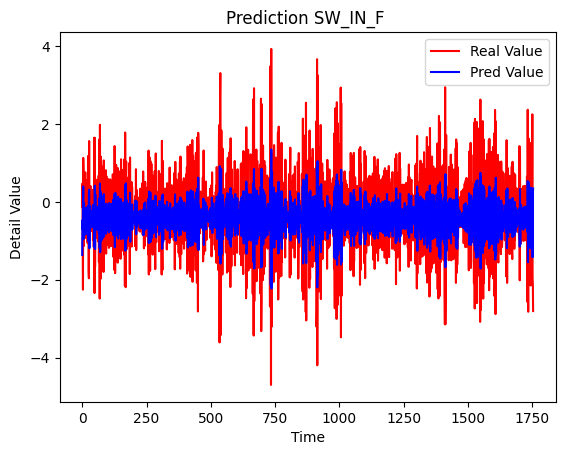

MSE: 0.944650094411116
MAE: 0.7375298266473347
R²: 0.14981501661695196
RMSE: 0.9719311160833961


In [143]:
Result_Ana(best_model, 6)

## 3. Stacked LSTM

Multiple hidden LSTM layers can be stacked one on top of another in what is referred to as a Stacked LSTM model.

An LSTM layer requires a three-dimensional input and LSTMs by default will produce a two-dimensional output as an interpretation from the end of the sequence.

We can address this by having the LSTM output a value for each time step in the input data by setting the return_sequences=True argument on the layer. This allows us to have 3D output from hidden LSTM layer as input to the next.

In [17]:
# univariate stacked lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import keras.backend as K


# def Stack_LSTM():
#     model = Sequential()
#     model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(1, 6)))
#     model.add(LSTM(100, activation='relu'))
#     model.add(Dense(1))
#     model.compile(optimizer='adam', loss='mse')
#     return model
def create_model(optimizer='adam', batch_size=32, epochs=40):
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(1, 6)))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Stack_LSTM_Model = KerasRegressor(build_fn=create_model(), epochs=40, verbose=1, validation_data=(testX, testY))
Stack_LSTM_Model = KerasRegressor(create_model,verbose=1)
# history = Stack_LSTM().fit(trainX,trainY,epochs=30,verbose=1,validation_data=(testX, testY))

# Stack_LSTM_Model = KerasRegressor(Stack_LSTM,epochs=30,verbose=1, validation_data=(testX, testY))

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_35732\4008304438.py:25: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  Stack_LSTM_Model = KerasRegressor(create_model,verbose=1)


In [18]:
from sklearn.model_selection import GridSearchCV

# 定义超参数搜索范围
param_grid = {
    'optimizer': ['adam'],
    'batch_size': [5,10,16, 32, 64],
    'epochs': [20,30, 40, 50]
}
# 执行网格搜索
grid = GridSearchCV(estimator=Stack_LSTM_Model, param_grid=param_grid, cv=2)
grid_result = grid.fit(trainX, trainY)

Epoch 1/20
702/702 [==============================] - 2s 1ms/step - loss: 0.0143
Epoch 2/20
702/702 [==============================] - 1s 1ms/step - loss: 0.0048
Epoch 3/20
702/702 [==============================] - 1s 1ms/step - loss: 0.0046
Epoch 4/20
702/702 [==============================] - 1s 1ms/step - loss: 0.0046
Epoch 5/20
702/702 [==============================] - 1s 971us/step - loss: 0.0045
Epoch 6/20
702/702 [==============================] - 1s 1ms/step - loss: 0.0045
Epoch 7/20
702/702 [==============================] - 1s 1ms/step - loss: 0.0044
Epoch 8/20
702/702 [==============================] - 1s 980us/step - loss: 0.0046
Epoch 9/20
702/702 [==============================] - 1s 1ms/step - loss: 0.0045
Epoch 10/20
702/702 [==============================] - 1s 1ms/step - loss: 0.0043
Epoch 11/20
702/702 [==============================] - 1s 1ms/step - loss: 0.0044
Epoch 12/20
702/702 [==============================] - 1s 981us/step - loss: 0.0044
Epoch 13/20
702/702

In [112]:
# 假设已经完成超参数优化并获得了最佳模型
best_model = grid_result.best_estimator_

# 使用最佳模型进行预测
y_pred = best_model.predict(testX)


351/351 [==============================] - 0s 800us/step


In [26]:
%%time
Stack_LSTM_Model.fit(trainX, trainY)

Epoch 1/40
220/220 [==============================] - 3s 3ms/step - loss: 0.0375 - val_loss: 0.0059
Epoch 2/40
220/220 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0055
Epoch 3/40
220/220 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0054
Epoch 4/40
220/220 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0055
Epoch 5/40
220/220 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0056
Epoch 6/40
220/220 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0059
Epoch 7/40
220/220 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0064
Epoch 8/40
220/220 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0060
Epoch 9/40
220/220 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0058
Epoch 10/40
220/220 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0056

In [43]:
original_copies_array = np.repeat(testY, 6, axis=-1)
y_true = scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), 6)))[-300:, 5]
y_true

array([ 0.236,  0.274,  0.28 ,  0.251,  0.159,  0.069,  0.009, -0.036,
       -0.012,  0.04 ,  0.17 ,  0.32 ,  0.464,  0.641,  0.743,  0.802,
        0.771,  0.647,  0.494,  0.342,  0.228,  0.152,  0.105,  0.111,
        0.139,  0.198,  0.235,  0.242,  0.177,  0.11 ,  0.029, -0.052,
       -0.083, -0.049,  0.034,  0.158,  0.357,  0.543,  0.681,  0.803,
        0.837,  0.767,  0.618,  0.455,  0.305,  0.15 ,  0.098,  0.057,
        0.056,  0.08 ,  0.145,  0.189,  0.209,  0.147,  0.058, -0.006,
       -0.04 , -0.063, -0.018,  0.077,  0.262,  0.445,  0.616,  0.726,
        0.817,  0.822,  0.753,  0.602,  0.423,  0.253,  0.135,  0.067,
        0.028,  0.029,  0.07 ,  0.144,  0.213,  0.229,  0.158,  0.078,
        0.017, -0.015, -0.017,  0.037,  0.154,  0.324,  0.499,  0.682,
        0.774,  0.853,  0.855,  0.767,  0.605,  0.429,  0.278,  0.16 ,
        0.1  ,  0.086,  0.11 ,  0.135,  0.187,  0.202,  0.167,  0.131,
        0.096,  0.034, -0.006, -0.003,  0.071,  0.192,  0.35 ,  0.501,
      

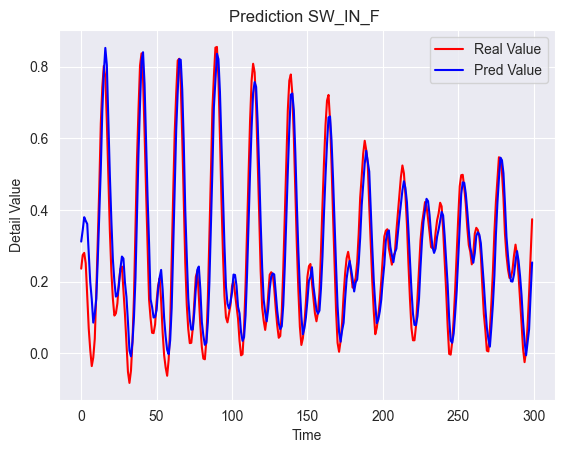

MSE: 0.0067089127084201195
MAE: 0.06759614620472615
R²: 0.8631584597522174
RMSE: 0.08190795265674829


In [20]:

y_pred = np.array(y_pred).reshape(-1, 1)
y_pred
y_pred.shape
prediction_copies_array = np.repeat(y_pred, 6,axis=-1)  #将一个数组prediction在最后一个轴上（即axis=-1）进行复制，重复8次，并将结果存储在prediction_copies_array数组中

pred = scaler.inverse_transform(np.reshape(prediction_copies_array, (len(y_pred), 6)))[:,5]  #进行逆变换但是，只需要最后一列

# print(pred)
original_copies_array = np.repeat(testY, 6, axis=-1)
y_true = scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), 6)))[:, 5]
y_true = y_true[-300:]
# print('y_true2:',y_true)
pred = pred[-300:]
# y_true = y_true[len(y_true)-test_len:len(y_true)-test_len+300]
# pred = pred[len(pred)-test_len:len(pred)-test_len+300]
plt.plot(y_true, color='red', label='Real Value')
plt.plot(pred, color='blue', label='Pred Value')
plt.title('Prediction SW_IN_F ')
plt.xlabel('Time')
plt.ylabel('Detail Value')
plt.legend()
# plt.savefig('../Images/SW_IN_F_Train_'+'n_past='+'{}'.format((trainX[1].shape)[0])+'_epochs={}'.format((grid_search.best_params_)['epochs'])+'.png',dpi=600)
plt.show()
    # y_true_data = pd.DataFrame(y)
    # y_true_data.to_csv('../ResultAnaAndProcess/Result/All Features/RF/37390_300/' + 'RF_{}'.format(site_name) + '_True' + '.csv',
    #               index=False)
    # pred_data = pd.DataFrame(pred)
    # pred_data.to_csv('../ResultAnaAndProcess/Result/All Features/RF/37390_300/' + 'RF_{}'.format(site_name) + '_Pre' + '.csv',
    #              index=False)
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
print('MSE:',mse(y_true,pred))
print('MAE:',mae(y_true,pred))
print('R²:',r2(y_true,pred))
print('RMSE:',np.sqrt(mse(y_true,pred)))


260/260 [==============================] - 0s 730us/step


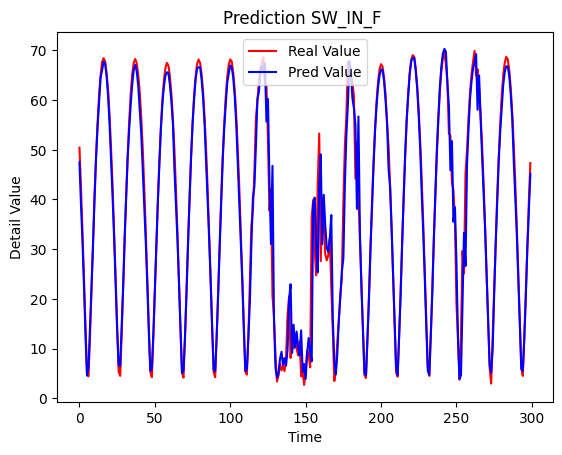

MSE: 20.231533142091948
MAE: 2.447641104917146
R²: 0.958271550878135
RMSE: 4.497947658887545


In [251]:
Result_Ana(Stack_LSTM_Model, 14)

## 4. Bidirectional LSTM


On some sequence prediction problems, it can be beneficial to allow the LSTM model to learn the input sequence both forward and backwards and concatenate both interpretations.

This is called a Bidirectional LSTM.

We can implement a Bidirectional LSTM for univariate time series forecasting by wrapping the first hidden layer in a wrapper layer called Bidirectional.

In [243]:
# univariate bidirectional lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
import keras.backend as K


def BiLSTM():
    model = Sequential()
    model.add(Bidirectional(LSTM(200, activation='relu'), input_shape=(1, 14)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model


# BiLSTM_Model = BiLSTM()
# history = BiLSTM_Model.fit(trainX,trainY,epochs=30,verbose=1,validation_data=(testX, testY))
BiLSTM_Model = KerasRegressor(BiLSTM, epochs=40, verbose=1, validation_data=(testX, testY))
# Access the training and validation loss values
# train_loss = history.history['loss']
# val_loss = history.history['val_loss']

# Print the training and validation loss values for each epoch
# for epoch in range(len(train_loss)):
#     print("Epoch {}: Train Loss = {}, Val Loss = {}".format(epoch+1, train_loss[epoch], val_loss[epoch]))

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_429876\2549510797.py:20: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  BiLSTM_Model = KerasRegressor(BiLSTM, epochs=40, verbose=1, validation_data=(testX, testY))


In [244]:
%%time
BiLSTM_Model.fit(trainX, trainY)

Epoch 1/40
1039/1039 [==============================] - 4s 2ms/step - loss: 0.0119 - val_loss: 0.0096
Epoch 2/40
1039/1039 [==============================] - 2s 2ms/step - loss: 0.0073 - val_loss: 0.0087
Epoch 3/40
1039/1039 [==============================] - 2s 2ms/step - loss: 0.0068 - val_loss: 0.0076
Epoch 4/40
1039/1039 [==============================] - 2s 2ms/step - loss: 0.0067 - val_loss: 0.0070
Epoch 5/40
1039/1039 [==============================] - 2s 2ms/step - loss: 0.0065 - val_loss: 0.0071
Epoch 6/40
1039/1039 [==============================] - 2s 2ms/step - loss: 0.0064 - val_loss: 0.0068
Epoch 7/40
1039/1039 [==============================] - 2s 2ms/step - loss: 0.0063 - val_loss: 0.0068
Epoch 8/40
1039/1039 [==============================] - 2s 2ms/step - loss: 0.0063 - val_loss: 0.0077
Epoch 9/40
1039/1039 [==============================] - 2s 2ms/step - loss: 0.0062 - val_loss: 0.0065
Epoch 10/40
1039/1039 [==============================] - 2s 2ms/step - loss: 0.006

260/260 [==============================] - 0s 694us/step


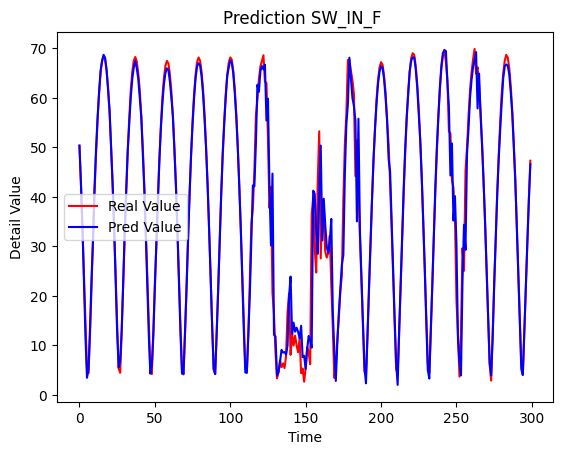

MSE: 18.903129224585264
MAE: 2.2113973837228937
R²: 0.9610114438410482
RMSE: 4.347772903980297


In [245]:
Result_Ana(BiLSTM_Model, 14)

## 5. CNN LSTM 

A convolutional neural network, or CNN for short, is a type of neural network developed for working with two-dimensional image data.

The CNN can be very effective at automatically extracting and learning features from one-dimensional sequence data such as univariate time series data.

In [ ]:
# # split a univariate sequence into samples
# def split_sequence(sequence, n_steps):
# 	X, y = list(), list()
# 	for i in range(len(sequence)):
# 		# find the end of this pattern
# 		end_ix = i + n_steps
# 		# check if we are beyond the sequence
# 		if end_ix > len(sequence)-1:
# 			break
# 		# gather input and output parts of the pattern
# 		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
# 		X.append(seq_x)
# 		y.append(seq_y)
# 	return array(X), array(y)

# # define input sequence
# raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# # choose a number of time steps
# n_steps = 4
# # split into samples
# X, y = split_sequence(raw_seq, n_steps)
# # reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
# n_features = 1
# n_seq = 1
# n_steps = 2
# X = X.reshape((X.shape[0], n_seq, n_steps, n_features))

In [11]:
# Reshape trainX and testX to (samples, timesteps, features)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))


In [ ]:
trainX.shape

In [ ]:
testX.shape

In [ ]:
trainX.shape

In [12]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten
from keras.layers import Conv1D, MaxPooling1D

# Reshape trainX and testX to (samples, timesteps, features)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[2], trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[2], testX.shape[1]))


# Define model
def CnnLSTM():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model


# Train the model
CnnLSTM_Model = CnnLSTM().fit(trainX, trainY, epochs=30, verbose=1, validation_data=(testX, testY))

Epoch 1/30
784/784 [==============================] - 4s 4ms/step - loss: 0.0158 - val_loss: 0.0106
Epoch 2/30
784/784 [==============================] - 3s 3ms/step - loss: 0.0111 - val_loss: 0.0108
Epoch 3/30
784/784 [==============================] - 3s 3ms/step - loss: 0.0107 - val_loss: 0.0099
Epoch 4/30
784/784 [==============================] - 3s 3ms/step - loss: 0.0104 - val_loss: 0.0098
Epoch 5/30
784/784 [==============================] - 3s 3ms/step - loss: 0.0102 - val_loss: 0.0098
Epoch 6/30
784/784 [==============================] - 3s 3ms/step - loss: 0.0101 - val_loss: 0.0104
Epoch 7/30
784/784 [==============================] - 3s 3ms/step - loss: 0.0099 - val_loss: 0.0096
Epoch 8/30
784/784 [==============================] - 3s 3ms/step - loss: 0.0097 - val_loss: 0.0095
Epoch 9/30
784/784 [==============================] - 3s 3ms/step - loss: 0.0097 - val_loss: 0.0102
Epoch 10/30
784/784 [==============================] - 3s 3ms/step - loss: 0.0096 - val_loss: 0.0096

196/196 [==============================] - 0s 2ms/step


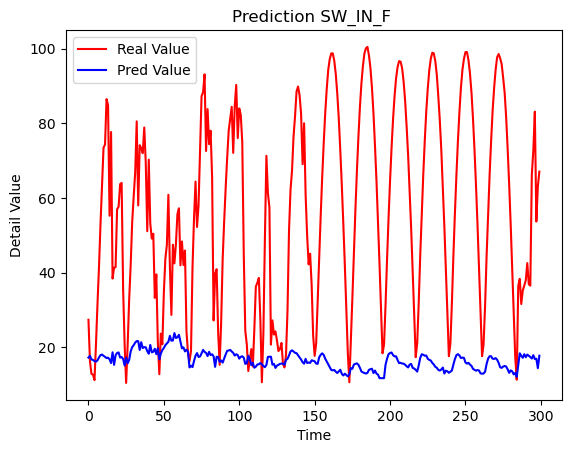

MSE: 2313.696828008055
MAE: 40.405593499144295
R²: -2.2840915325750046
RMSE: 48.1009025695782


In [15]:
Result_Ana(CnnLSTM(), 14)

In [ ]:
# univariate cnn lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D


# define model
def CnnLSTM():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model


CnnLSTM_Model = CnnLSTM().fit(trainX, trainY, epochs=30, verbose=1, validation_data=(testX, testY))

In [ ]:
# demonstrate prediction
# x_input = array([60, 70, 80, 90])
# x_input = x_input.reshape((1, n_seq, n_steps, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 4
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# # reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
# n_features = 1
# n_seq = 2
# n_steps = 2
# X = X.reshape((X.shape[0], n_seq, n_steps, n_features))

In [ ]:
X

In [ ]:
X.shape

## 6. ConvLSTM

A type of LSTM related to the CNN-LSTM is the ConvLSTM, where the convolutional reading of input is built directly into each LSTM unit.

The ConvLSTM was developed for reading two-dimensional spatial-temporal data, but can be adapted for use with univariate time series forecasting.

In [ ]:
# univariate convlstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D


# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 4
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))
# define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1, 2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=500, verbose=0)
# demonstrate prediction
x_input = array([60, 70, 80, 90])
x_input = x_input.reshape((1, n_seq, 1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

* ## Multivariate LSTM Models

Multivariate time series data means data where there is more than one observation for each time step.



In [ ]:
# multivariate lstm example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense


# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix - 1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i] + in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)
# demonstrate prediction
x_input = array([[80, 85], [90, 95], [100, 105]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

* ##  Multi-Step LSTM Models

A time series forecasting problem that requires a prediction of multiple time steps into the future can be referred to as multi-step time series forecasting

In [ ]:
# univariate multi-step vector-output stacked lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense


# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=50, verbose=0)
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

* ## Encoder-Decoder LSTM


In [ ]:
# univariate multi-step encoder-decoder lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed


# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=100, verbose=0)
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

* ## Multivariate Multi-Step LSTM Models


In [ ]:
# multivariate multi-step stacked lstm example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense


# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix - 1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i] + in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# covert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)
# demonstrate prediction
x_input = array([[70, 75], [80, 85], [90, 95]])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

Reference:-  https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecastings/